## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
from openpyxl.utils import get_column_letter
from collections import OrderedDict
import json

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
EPOCHS = 50
T = 10

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Data Loading

In [3]:
def load_data(*file_paths):
    """
    Returns:
        X (numpy.ndarray): Features array
        y (numpy.ndarray): Labels array
    """
    
    if len(file_paths) == 1:  # Single .npz file
        file_path = file_paths[0]
        
        if not file_path.endswith(".npz"):
            raise ValueError("Single input must be a .npz file")
            
        with np.load(file_path) as data:
            X = data["X"]
            y = data["y"]

    elif len(file_paths) == 2:  # Two .npy files
        x_path, y_path = file_paths
        
        if not (x_path.endswith(".npy") and y_path.endswith(".npy")):
            raise ValueError("When providing two inputs, both must be .npy files")
            
        X = np.load(x_path)
        y = np.load(y_path)

    return X, y

## Checking Distributions

In [4]:
def plot_input_dist(X):
    X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()
    
    for i in range(6):
        axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
        axs[i].set_title(f'Channel {i+1}')
    plt.tight_layout()
    plt.show()


def plot_label_dist(y):
    # Checking the label distribution of training data
    print('\n\n====== Label Distribution ======')
    unique_labels, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
    print("-" * 30)
    for label, count in zip(unique_labels, counts):
        percentage = (count / total) * 100
        print(f"{label:<10}{count:<10}{percentage:<.2f}%")
    
    print(f"\nTotal samples: {total}")
    
    # Plot histogram for training data
    unique_labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Label Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Input Preprocessing

In [5]:
def normalize(X):
    # Standardizing the input features across all timesteps and samples using Z-scores
    # Compute per-feature mean and std across all samples and timesteps
    feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
    feature_stds = X.std(axis=(0, 1))    # Shape: (6,)
    
    # Reshape for broadcasting
    feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
    feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)
    
    # Standardize
    X = ((X - feature_means) / feature_stds).astype(np.float32)
    return X

## Dataset Class

In [6]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {"x": self.X[idx], "y": self.y[idx]}

## Model

In [7]:
def conv_block(in_channels: int, out_channels: int, dropout_p=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )

In [8]:
################ CNN Backbone
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [9]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

In [10]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

## Evaluation

In [11]:
def mc_dropout_eval(backbone, fc, dataloader, class_weights=None, T=T):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(DEVICE)
            y = batch["y"].to(DEVICE)
            all_labels.append(y.cpu())

            logits_T = []
            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                logits_T.append(logits)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            logits_T = torch.stack(logits_T, dim=0)  # (T, B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            # ===== Compute loss =====
            ce_t = [F.cross_entropy(l, y, weight=class_weights, reduction="mean") for l in logits_T]
            loss = torch.stack(ce_t).mean()
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

    avg_loss = total_loss / total_samples

    return avg_loss, acc, avg_f1, per_class_f1, kappa, cm

## Training

In [12]:
def train(backbone, fc, train_loader, val_loader, device, class_weights=None, epochs=EPOCHS, T=T):
    backbone.train()
    fc.train()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s, val_per_class_f1s, val_kappas = [], [], []

    optimizer = torch.optim.AdamW(list(backbone.parameters()) + list(fc.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    for epoch in range(epochs):
        backbone.train()
        fc.train()
        
        running_loss = 0.0
        correct = 0
        total_samples = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt, weight=class_weights)
            loss.backward()
            optimizer.step()

            batch_size = yt.size(0)
            running_loss += loss.item() * batch_size
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc = correct / total_samples
        
        # Validation
        val_loss, val_acc, val_avg_f1, val_per_class_f1, val_kappa, _ = mc_dropout_eval(backbone, fc, val_loader, class_weights=class_weights, T=T)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_kappas.append(val_kappa)
        val_f1s.append(val_avg_f1)
        val_per_class_f1s.append(val_per_class_f1)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"F1: {val_avg_f1:.4f}, Kappa: {val_kappa:.4f}")  

    return train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s

## Plotting

In [13]:
def plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS):
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))  

    # --- Plot Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Validation F1 ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1s, label='Val F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Saving Results

In [14]:
def save_results(output_file, history):
    # ensure .xlsx extension
    if not output_file.lower().endswith(".xlsx"):
        output_file = output_file + ".xlsx"

    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for file_name, h in history.items():
            # ---------------------------
            # Per-epoch logs
            # ---------------------------
            df_epochs = pd.DataFrame({
                "epoch": list(range(1, len(h["train_loss"]) + 1)),
                "train_loss": h["train_loss"],
                "train_acc": h["train_acc"],
                "val_loss": h["val_loss"],
                "val_acc": h["val_acc"],
                "val_f1": h["val_f1s"],
                "val_kappa": h["val_kappas"],
                "val_per_class_f1": [
                    ",".join(map(str, f1s)) if f1s is not None else None 
                    for f1s in h["val_per_class_f1s"]
                ]
            })

            # ---------------------------
            # Final test metrics
            # ---------------------------
            final_metrics = {
                "metric": [
                    "overall_loss",
                    "overall_acc",
                    "kappa",
                    "avg_f1",
                    "per_class_f1",
                    "cm"
                ],
                "value": [
                    h["overall_loss"],
                    h["overall_acc"],
                    h["kappa"],
                    h["avg_f1"],
                    ",".join(map(str, h["per_class_f1"])) if h["per_class_f1"] is not None else None,
                    str(h["cm"]) if h["cm"] is not None else None
                ]
            }
            df_final = pd.DataFrame(final_metrics)

            # ---------------------------
            # Write to Excel
            # ---------------------------
            sheet_name = os.path.basename(file_name)[:31]  # Excel sheet name max length = 31
            df_epochs.to_excel(writer, sheet_name=sheet_name, index=False, startrow=0)
            startrow = len(df_epochs) + 2
            df_final.to_excel(writer, sheet_name=sheet_name, index=False, startrow=startrow)

        # ---------------------------
        # Auto-adjust column widths
        # ---------------------------
        for sheet_name, worksheet in writer.sheets.items():
            for col_idx, col_cells in enumerate(worksheet.columns, 1):
                max_length = 0
                col_letter = get_column_letter(col_idx)
                for cell in col_cells:
                    try:
                        if cell.value:
                            max_length = max(max_length, len(str(cell.value)))
                    except:
                        pass
                worksheet.column_dimensions[col_letter].width = max_length + 2

    print(f"Saved history of all files to {output_file}")

In [15]:
def save_history(history, name, output_dir="/kaggle/working"):
    def convert(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (set, tuple)):
            return list(obj)
        return obj

    # Remove ".npz" if present
    base_name = os.path.basename(name).replace(".npz", "")
    output_file = os.path.join(output_dir, f"{base_name}_history.json")

    with open(output_file, "w") as f:
        json.dump(history, f, default=convert, indent=4)

    print(f'History Dumped in file {output_file}')

## Start

In [16]:
data_dir = "/kaggle/input/data-al"
file_names = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
file_names = file_names[4:9]

for name in file_names:
    print(name)

X_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy'
y_B2020_path = f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy'

/kaggle/input/data-al/data_random.npz
/kaggle/input/data-al/deterministic_CNN_data_diversity.npz
/kaggle/input/data-al/deterministic_CNN_data_entropy.npz
/kaggle/input/data-al/deterministic_CNN_data_entropy_diversity.npz
/kaggle/input/data-al/deterministic_CNN_data_margin.npz


In [17]:
history = {}

for name in file_names:
    history[name] = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [], 
        'val_acc': [],
        'val_f1s': [],
        'val_kappas': [],
        'val_per_class_f1s': [],
        
        'overall_loss': None,
        'overall_acc': None,
        'kappa': None,
        'avg_f1': None,
        'per_class_f1': None,
        'cm': None
    }



====== Loading Data /kaggle/input/data-al/data_random.npz ======
Train Data:  (14000, 28, 6) (14000,)


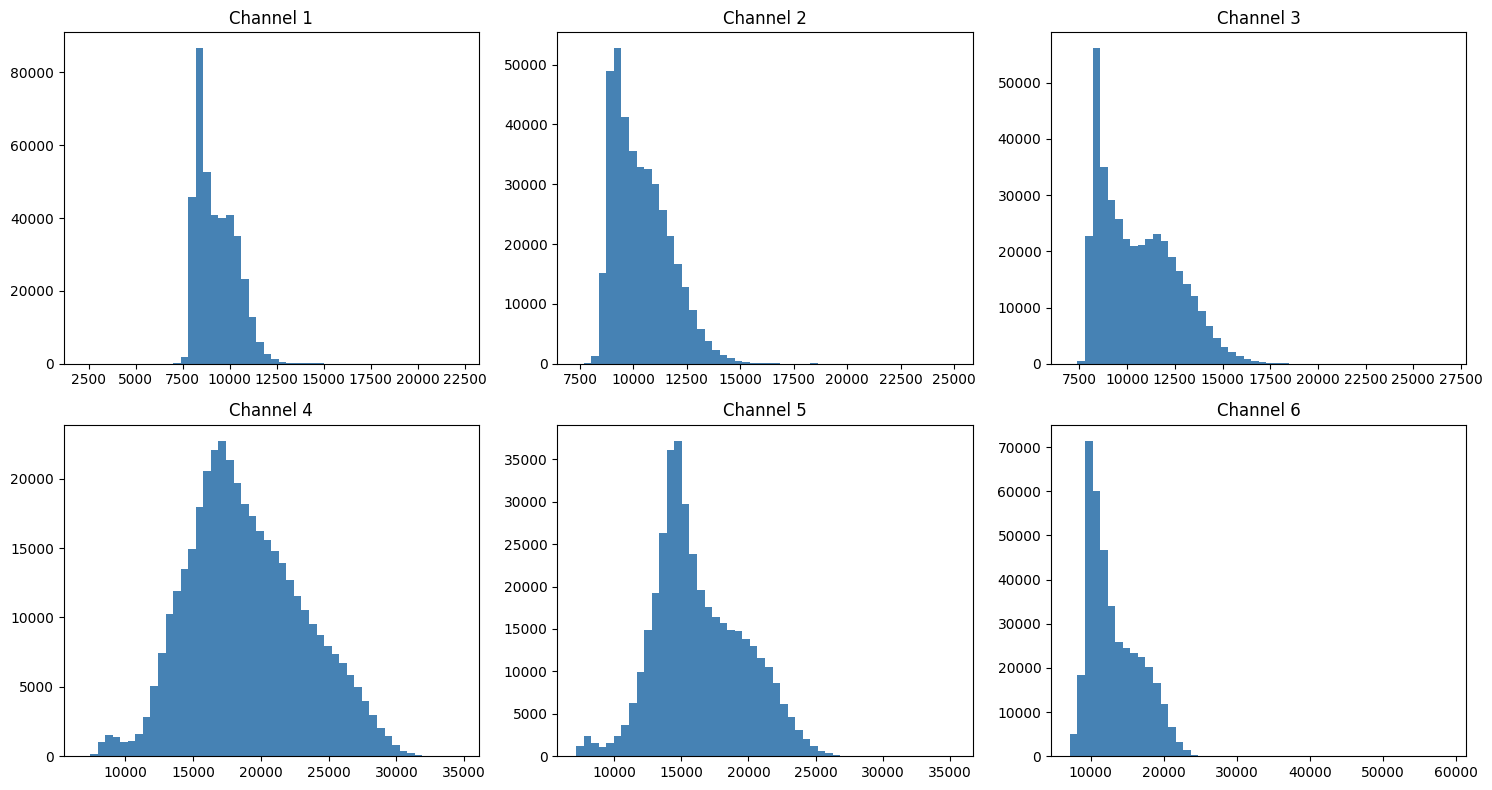

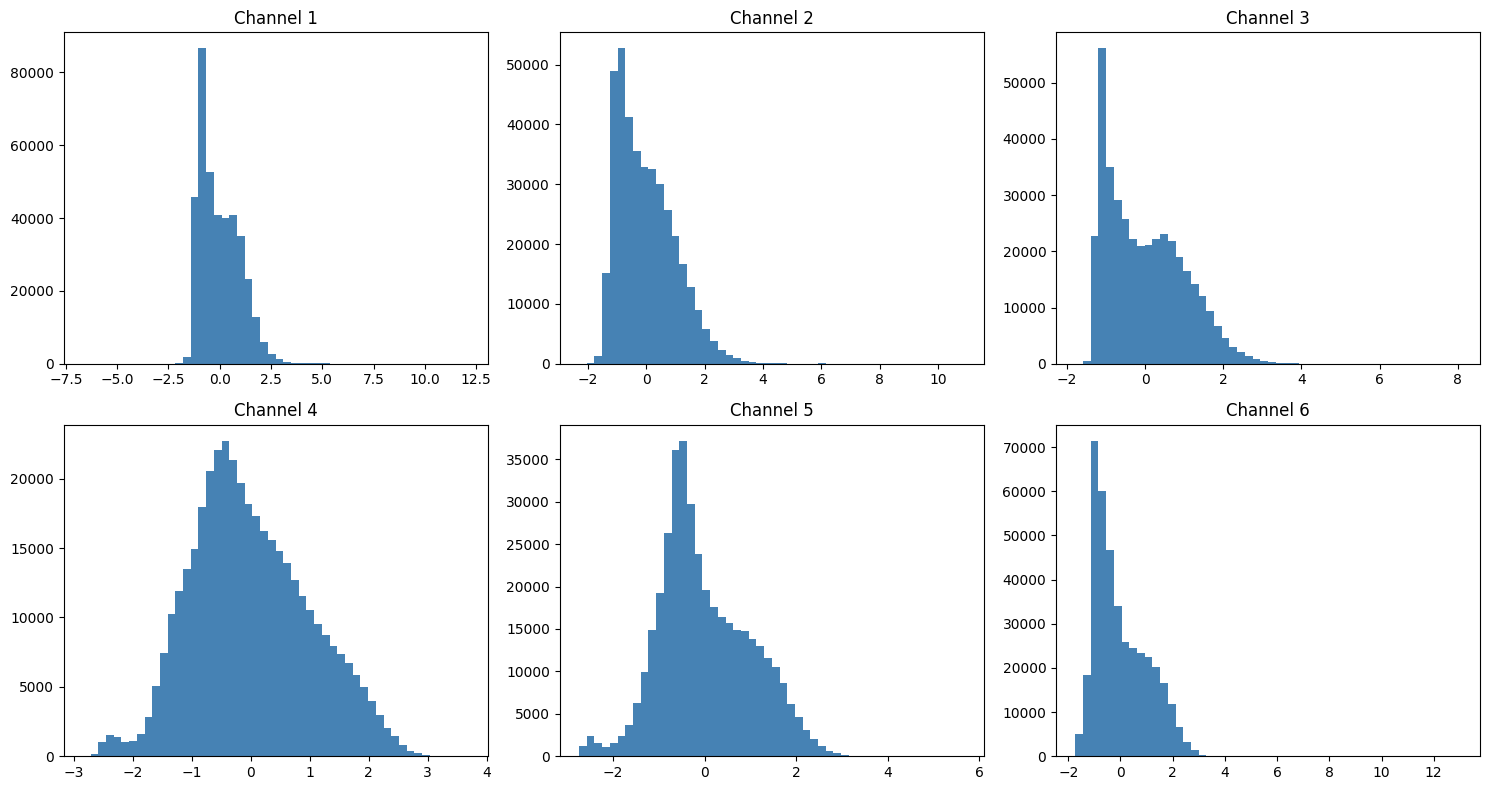



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6266      44.76%
1         2002      14.30%
2         5732      40.94%

Total samples: 14000


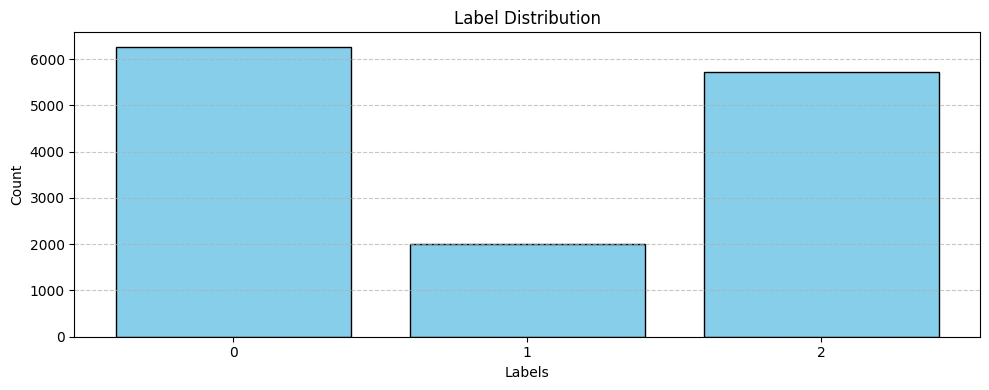


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


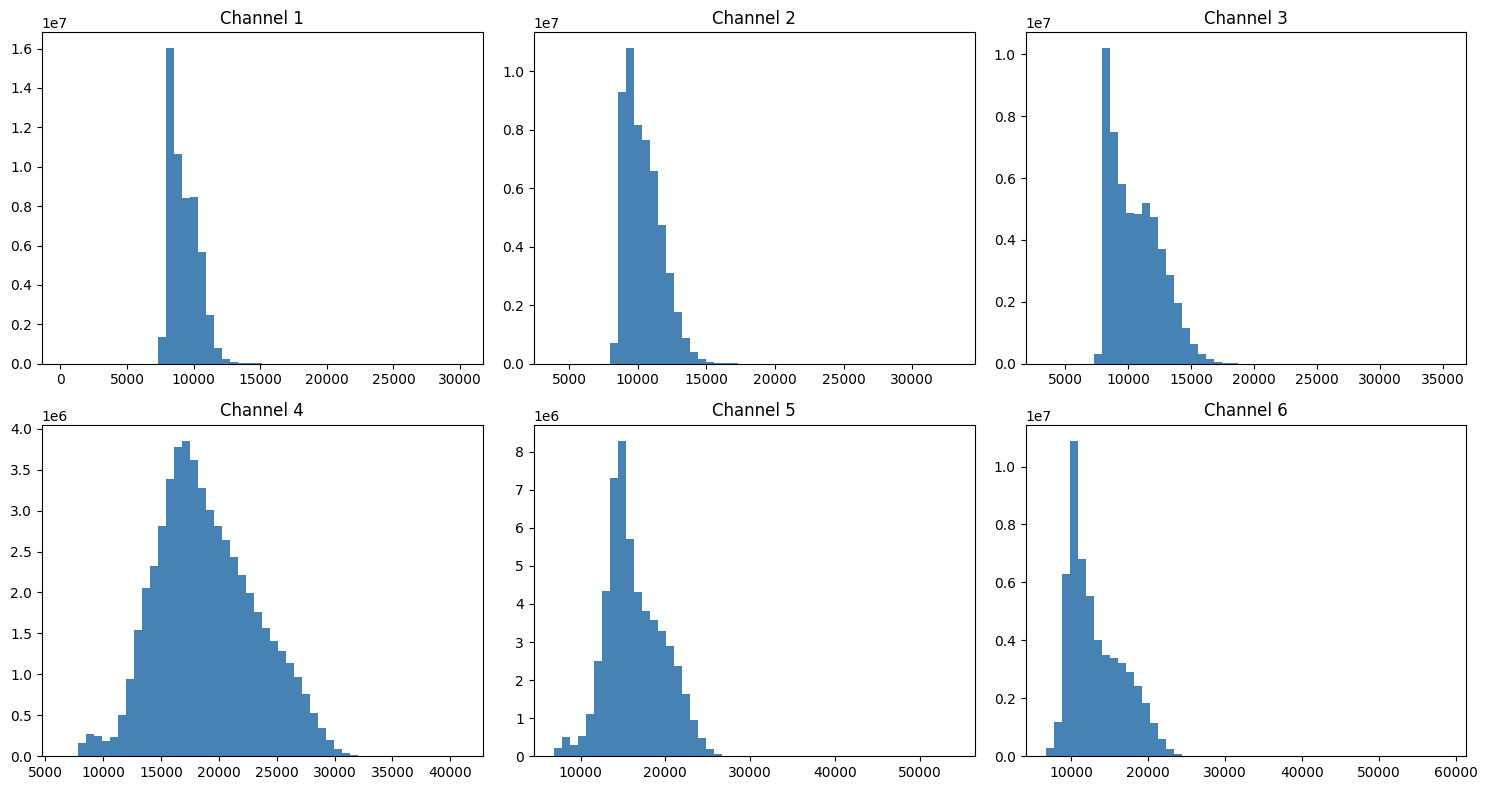

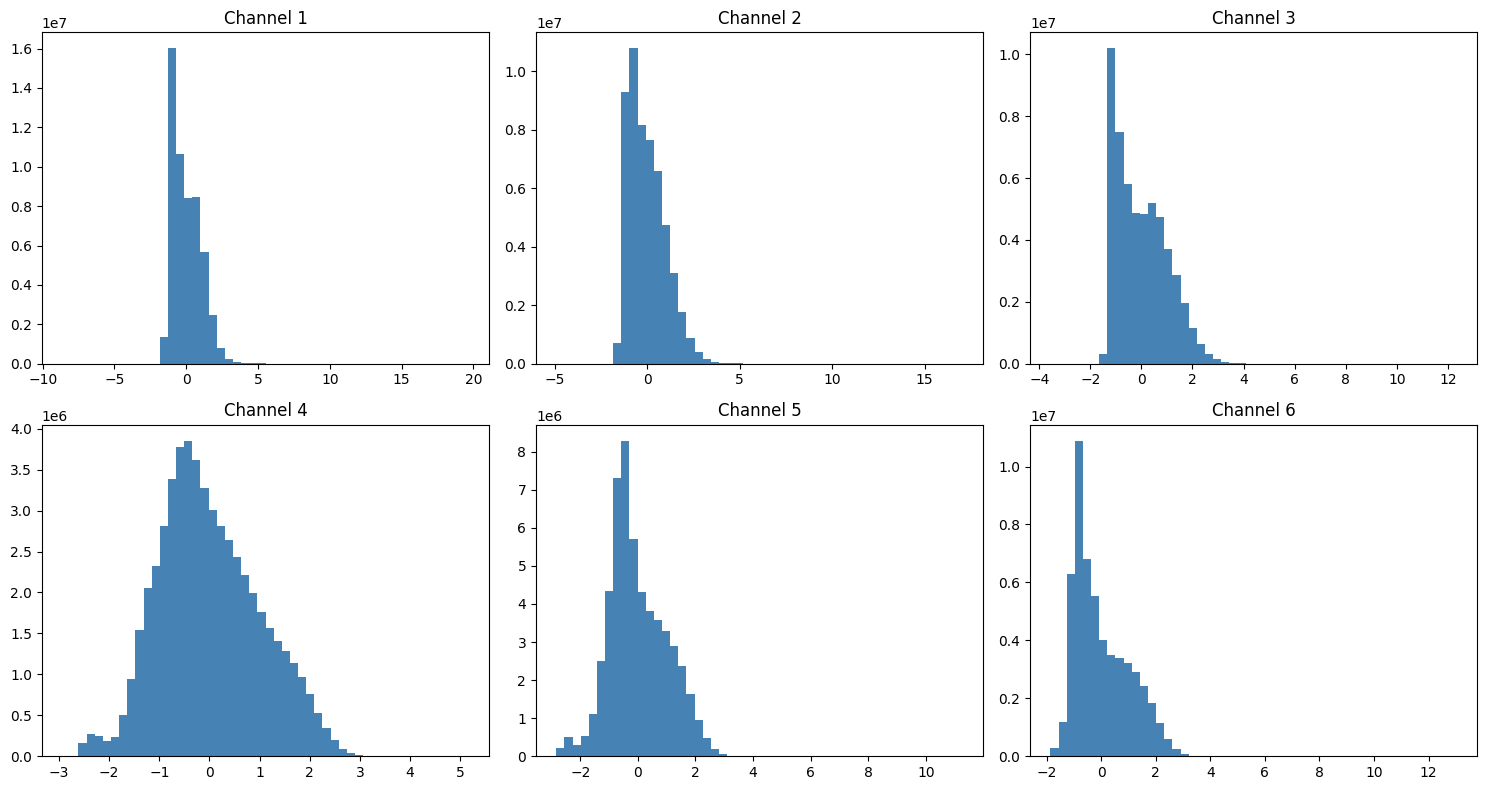



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


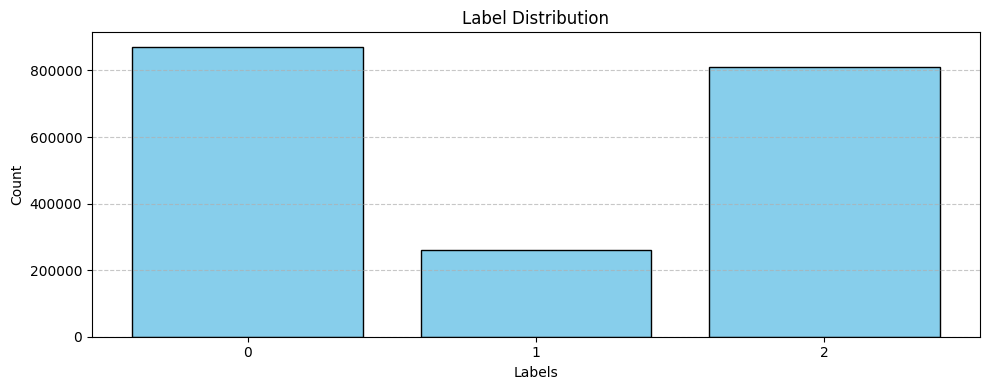

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5566, 1.2033, 0.5956], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [1/50] Train Loss: 0.5547, Train Acc: 0.8077 | Val Loss: 0.4083, Val Acc: 0.8610, F1: 0.8645, Kappa: 0.7710


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [2/50] Train Loss: 0.3725, Train Acc: 0.8442 | Val Loss: 0.3412, Val Acc: 0.8767, F1: 0.8747, Kappa: 0.7986


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [3/50] Train Loss: 0.3313, Train Acc: 0.8642 | Val Loss: 0.4828, Val Acc: 0.8191, F1: 0.8264, Kappa: 0.7064


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.98it/s]


Epoch [4/50] Train Loss: 0.3148, Train Acc: 0.8698 | Val Loss: 0.3171, Val Acc: 0.8793, F1: 0.8757, Kappa: 0.8036


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [5/50] Train Loss: 0.3072, Train Acc: 0.8752 | Val Loss: 0.3013, Val Acc: 0.8814, F1: 0.8786, Kappa: 0.8064


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [6/50] Train Loss: 0.3097, Train Acc: 0.8726 | Val Loss: 0.3219, Val Acc: 0.8834, F1: 0.8840, Kappa: 0.8087


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [7/50] Train Loss: 0.2910, Train Acc: 0.8819 | Val Loss: 0.3020, Val Acc: 0.8863, F1: 0.8879, Kappa: 0.8131


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [8/50] Train Loss: 0.2874, Train Acc: 0.8839 | Val Loss: 0.3064, Val Acc: 0.8880, F1: 0.8882, Kappa: 0.8167


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [9/50] Train Loss: 0.2806, Train Acc: 0.8867 | Val Loss: 0.3111, Val Acc: 0.8907, F1: 0.8930, Kappa: 0.8203


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [10/50] Train Loss: 0.2800, Train Acc: 0.8831 | Val Loss: 0.2879, Val Acc: 0.8896, F1: 0.8875, Kappa: 0.8196


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [11/50] Train Loss: 0.2782, Train Acc: 0.8862 | Val Loss: 0.2964, Val Acc: 0.8815, F1: 0.8811, Kappa: 0.8064


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [12/50] Train Loss: 0.2693, Train Acc: 0.8895 | Val Loss: 0.3255, Val Acc: 0.8865, F1: 0.8904, Kappa: 0.8125


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.99it/s]


Epoch [13/50] Train Loss: 0.2692, Train Acc: 0.8914 | Val Loss: 0.2862, Val Acc: 0.8985, F1: 0.8981, Kappa: 0.8327


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [14/50] Train Loss: 0.2653, Train Acc: 0.8902 | Val Loss: 0.2788, Val Acc: 0.8894, F1: 0.8878, Kappa: 0.8190


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [15/50] Train Loss: 0.2581, Train Acc: 0.8942 | Val Loss: 0.2826, Val Acc: 0.8910, F1: 0.8879, Kappa: 0.8218


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [16/50] Train Loss: 0.2583, Train Acc: 0.8930 | Val Loss: 0.2893, Val Acc: 0.8952, F1: 0.8983, Kappa: 0.8273


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [17/50] Train Loss: 0.2579, Train Acc: 0.8960 | Val Loss: 0.3020, Val Acc: 0.8933, F1: 0.8949, Kappa: 0.8236


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [18/50] Train Loss: 0.2602, Train Acc: 0.8944 | Val Loss: 0.2814, Val Acc: 0.8933, F1: 0.8943, Kappa: 0.8248


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [19/50] Train Loss: 0.2507, Train Acc: 0.8953 | Val Loss: 0.2732, Val Acc: 0.8968, F1: 0.8951, Kappa: 0.8310


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [20/50] Train Loss: 0.2519, Train Acc: 0.8939 | Val Loss: 0.4204, Val Acc: 0.8401, F1: 0.8484, Kappa: 0.7371


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [21/50] Train Loss: 0.2505, Train Acc: 0.8975 | Val Loss: 0.2892, Val Acc: 0.8920, F1: 0.8929, Kappa: 0.8230


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [22/50] Train Loss: 0.2418, Train Acc: 0.9013 | Val Loss: 0.2850, Val Acc: 0.8932, F1: 0.8939, Kappa: 0.8248


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [23/50] Train Loss: 0.2388, Train Acc: 0.8999 | Val Loss: 0.3086, Val Acc: 0.8876, F1: 0.8840, Kappa: 0.8169


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [24/50] Train Loss: 0.2418, Train Acc: 0.9002 | Val Loss: 0.2717, Val Acc: 0.8981, F1: 0.8984, Kappa: 0.8328


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [25/50] Train Loss: 0.2379, Train Acc: 0.9006 | Val Loss: 0.2712, Val Acc: 0.8988, F1: 0.8979, Kappa: 0.8338


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [26/50] Train Loss: 0.2396, Train Acc: 0.8999 | Val Loss: 0.3135, Val Acc: 0.8823, F1: 0.8867, Kappa: 0.8072


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [27/50] Train Loss: 0.2448, Train Acc: 0.8993 | Val Loss: 0.2793, Val Acc: 0.8976, F1: 0.8979, Kappa: 0.8316


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [28/50] Train Loss: 0.2345, Train Acc: 0.9051 | Val Loss: 0.2807, Val Acc: 0.8977, F1: 0.8971, Kappa: 0.8324


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [29/50] Train Loss: 0.2309, Train Acc: 0.9040 | Val Loss: 0.2799, Val Acc: 0.8920, F1: 0.8898, Kappa: 0.8230


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.64it/s]


Epoch [30/50] Train Loss: 0.2242, Train Acc: 0.9079 | Val Loss: 0.2797, Val Acc: 0.8954, F1: 0.8935, Kappa: 0.8287


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [31/50] Train Loss: 0.2219, Train Acc: 0.9077 | Val Loss: 0.2729, Val Acc: 0.9005, F1: 0.9000, Kappa: 0.8367


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [32/50] Train Loss: 0.2054, Train Acc: 0.9139 | Val Loss: 0.2680, Val Acc: 0.9017, F1: 0.9010, Kappa: 0.8388


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.67it/s]


Epoch [33/50] Train Loss: 0.2033, Train Acc: 0.9164 | Val Loss: 0.2767, Val Acc: 0.9014, F1: 0.9015, Kappa: 0.8381


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.58it/s]


Epoch [34/50] Train Loss: 0.1944, Train Acc: 0.9181 | Val Loss: 0.2701, Val Acc: 0.9025, F1: 0.8997, Kappa: 0.8402


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [35/50] Train Loss: 0.1944, Train Acc: 0.9193 | Val Loss: 0.2700, Val Acc: 0.9070, F1: 0.9076, Kappa: 0.8469


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [36/50] Train Loss: 0.1930, Train Acc: 0.9173 | Val Loss: 0.2787, Val Acc: 0.9023, F1: 0.9011, Kappa: 0.8397


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [37/50] Train Loss: 0.1910, Train Acc: 0.9191 | Val Loss: 0.2722, Val Acc: 0.9047, F1: 0.9054, Kappa: 0.8434


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [38/50] Train Loss: 0.1945, Train Acc: 0.9176 | Val Loss: 0.2714, Val Acc: 0.9026, F1: 0.9014, Kappa: 0.8402


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [39/50] Train Loss: 0.1771, Train Acc: 0.9269 | Val Loss: 0.2759, Val Acc: 0.9006, F1: 0.8993, Kappa: 0.8373


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [40/50] Train Loss: 0.1752, Train Acc: 0.9248 | Val Loss: 0.2840, Val Acc: 0.9014, F1: 0.9008, Kappa: 0.8381


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [41/50] Train Loss: 0.1675, Train Acc: 0.9299 | Val Loss: 0.2924, Val Acc: 0.9027, F1: 0.9011, Kappa: 0.8403


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [42/50] Train Loss: 0.1666, Train Acc: 0.9307 | Val Loss: 0.2825, Val Acc: 0.9044, F1: 0.9049, Kappa: 0.8429


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [43/50] Train Loss: 0.1715, Train Acc: 0.9268 | Val Loss: 0.2823, Val Acc: 0.9001, F1: 0.8981, Kappa: 0.8362


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [44/50] Train Loss: 0.1612, Train Acc: 0.9331 | Val Loss: 0.2918, Val Acc: 0.9042, F1: 0.9033, Kappa: 0.8426


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [45/50] Train Loss: 0.1588, Train Acc: 0.9334 | Val Loss: 0.2864, Val Acc: 0.9025, F1: 0.9016, Kappa: 0.8399


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [46/50] Train Loss: 0.1542, Train Acc: 0.9361 | Val Loss: 0.2852, Val Acc: 0.9049, F1: 0.9048, Kappa: 0.8438


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [47/50] Train Loss: 0.1489, Train Acc: 0.9376 | Val Loss: 0.2986, Val Acc: 0.9034, F1: 0.9027, Kappa: 0.8413


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [48/50] Train Loss: 0.1549, Train Acc: 0.9336 | Val Loss: 0.2999, Val Acc: 0.9049, F1: 0.9040, Kappa: 0.8440


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [49/50] Train Loss: 0.1505, Train Acc: 0.9358 | Val Loss: 0.2986, Val Acc: 0.9049, F1: 0.9048, Kappa: 0.8436


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [50/50] Train Loss: 0.1523, Train Acc: 0.9341 | Val Loss: 0.2965, Val Acc: 0.9059, F1: 0.9052, Kappa: 0.8452


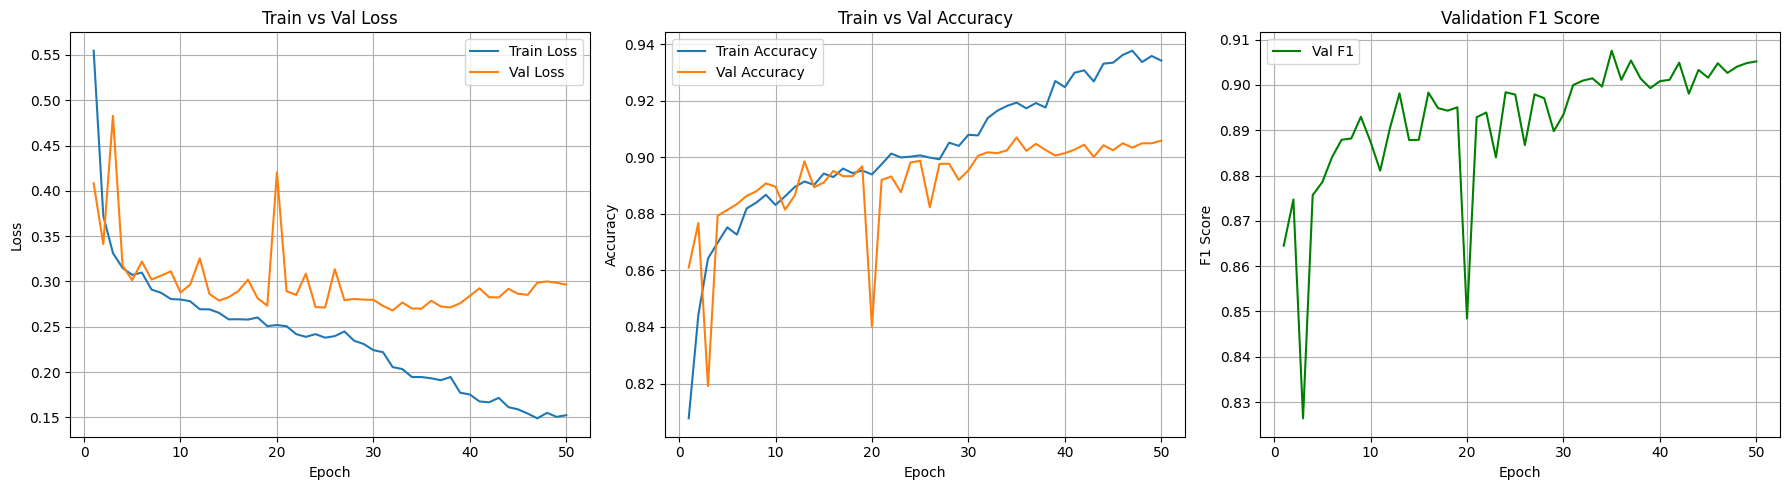


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:39<00:00, 39.80it/s]



====== Test Results ======
Overall Loss: 0.2912
Overall Accuracy: 0.9062
Cohen's Kappa: 0.8455
Per Class F1: [0.90723746 0.91156447 0.90329333]
Macro (Avg) F1: 0.9074


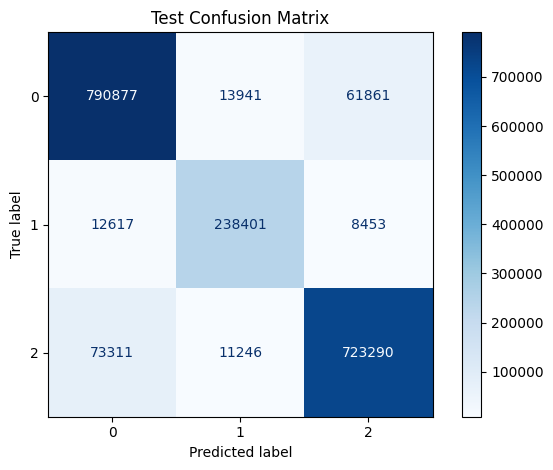

History Dumped in file /kaggle/working/data_random_history.json_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_diversity.npz ======
Train Data:  (14000, 28, 6) (14000,)


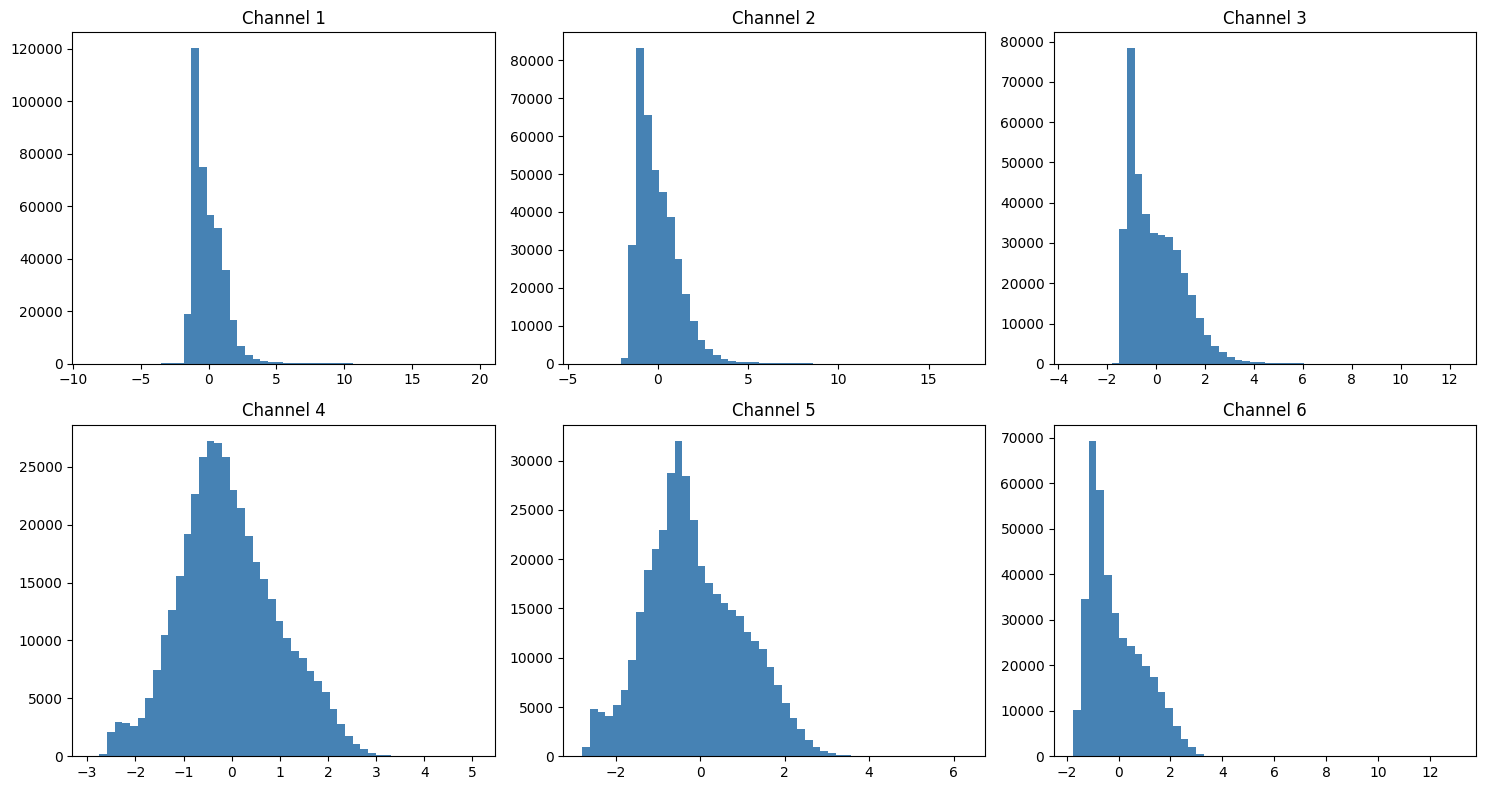

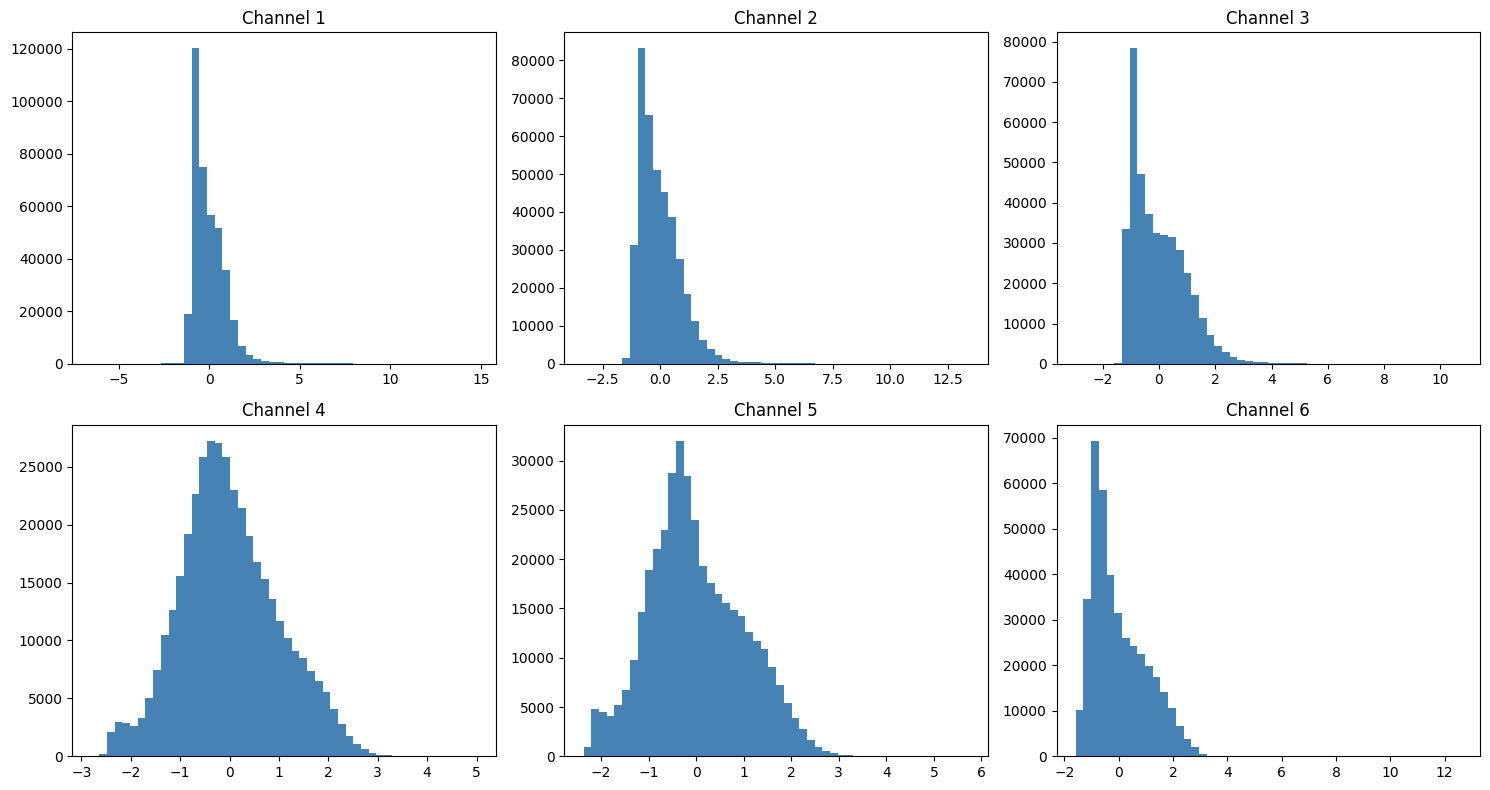



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         7790      55.64%
1         1414      10.10%
2         4796      34.26%

Total samples: 14000


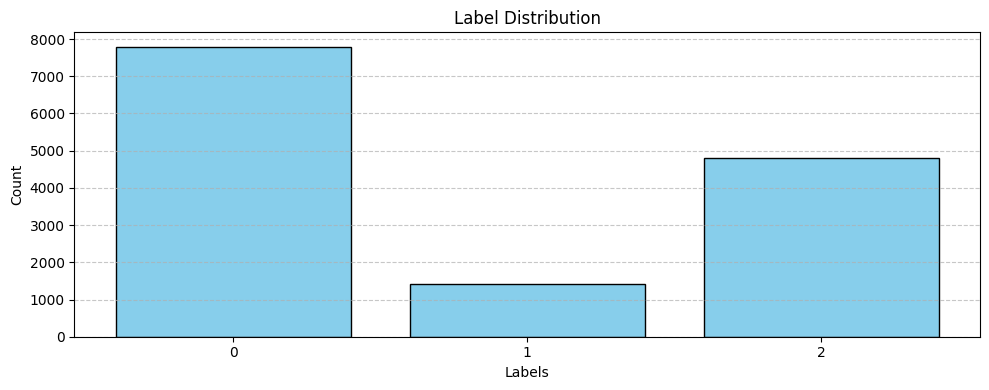


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


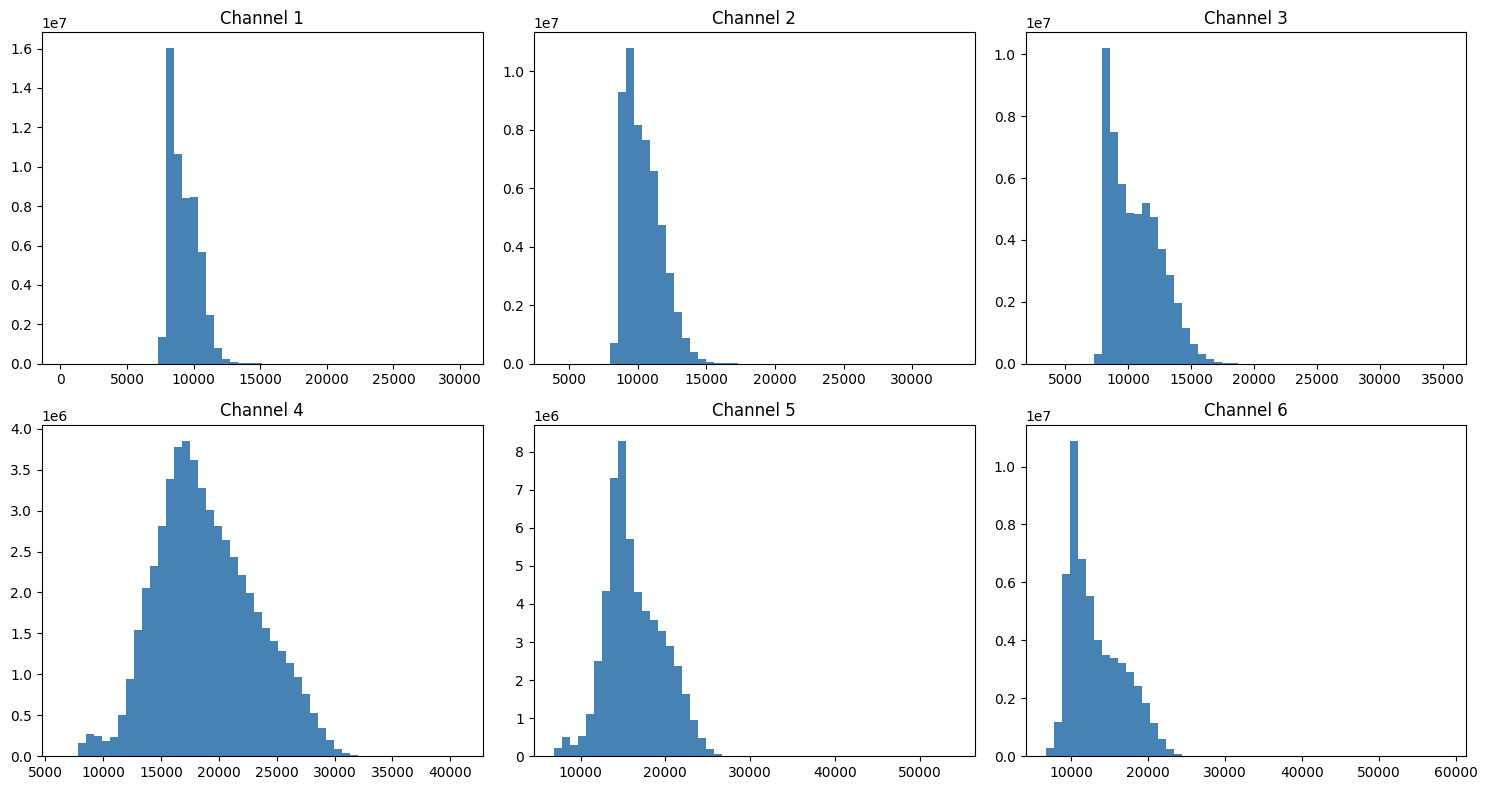

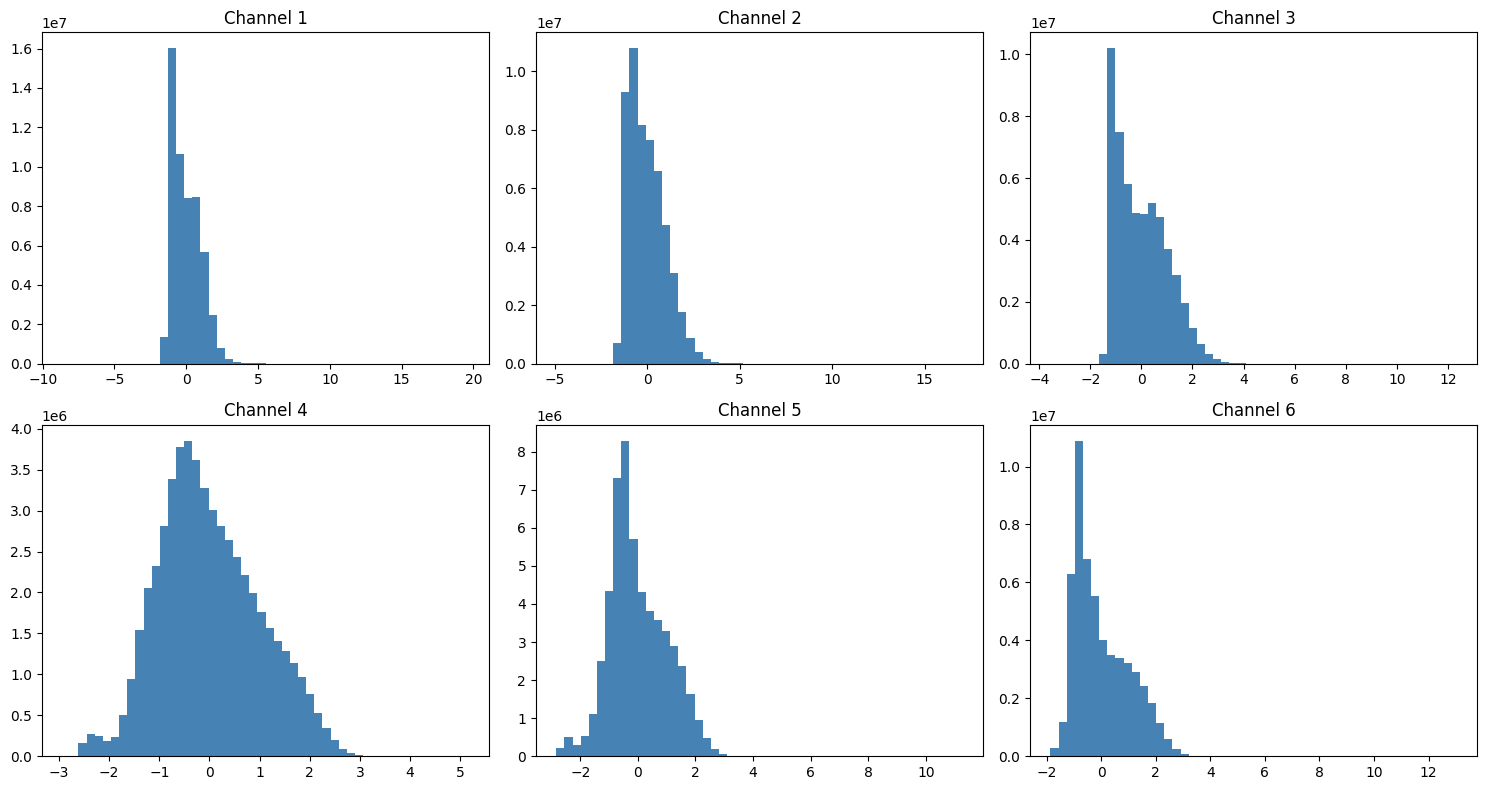



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


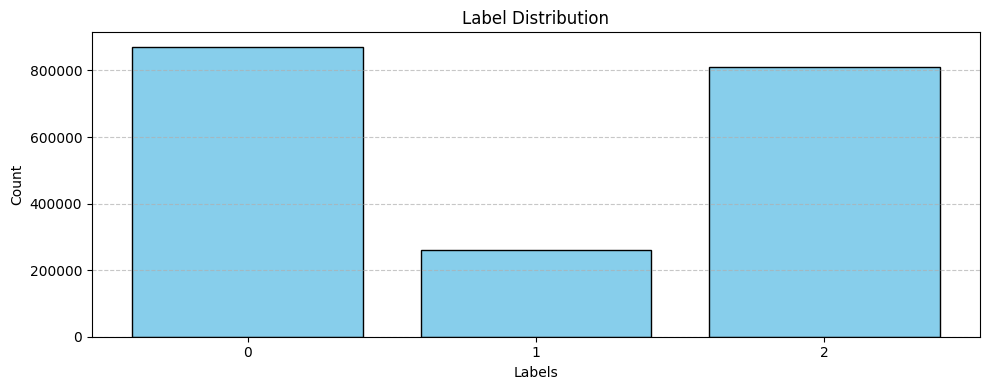

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.4694, 1.4587, 0.6796], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [1/50] Train Loss: 0.6971, Train Acc: 0.7461 | Val Loss: 0.4330, Val Acc: 0.8322, F1: 0.8403, Kappa: 0.7263


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.61it/s]


Epoch [2/50] Train Loss: 0.4858, Train Acc: 0.8014 | Val Loss: 0.3541, Val Acc: 0.8643, F1: 0.8660, Kappa: 0.7786


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [3/50] Train Loss: 0.4329, Train Acc: 0.8266 | Val Loss: 0.3863, Val Acc: 0.8530, F1: 0.8608, Kappa: 0.7588


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [4/50] Train Loss: 0.4150, Train Acc: 0.8334 | Val Loss: 0.3203, Val Acc: 0.8642, F1: 0.8662, Kappa: 0.7786


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.98it/s]


Epoch [5/50] Train Loss: 0.4014, Train Acc: 0.8390 | Val Loss: 0.3226, Val Acc: 0.8672, F1: 0.8661, Kappa: 0.7840


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [6/50] Train Loss: 0.3905, Train Acc: 0.8448 | Val Loss: 0.3216, Val Acc: 0.8706, F1: 0.8725, Kappa: 0.7885


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [7/50] Train Loss: 0.3827, Train Acc: 0.8481 | Val Loss: 0.3150, Val Acc: 0.8774, F1: 0.8765, Kappa: 0.7999


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [8/50] Train Loss: 0.3683, Train Acc: 0.8534 | Val Loss: 0.3388, Val Acc: 0.8729, F1: 0.8761, Kappa: 0.7914


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [9/50] Train Loss: 0.3672, Train Acc: 0.8536 | Val Loss: 0.3093, Val Acc: 0.8799, F1: 0.8763, Kappa: 0.8047


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [10/50] Train Loss: 0.3547, Train Acc: 0.8606 | Val Loss: 0.3187, Val Acc: 0.8680, F1: 0.8634, Kappa: 0.7867


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [11/50] Train Loss: 0.3620, Train Acc: 0.8558 | Val Loss: 0.3508, Val Acc: 0.8651, F1: 0.8710, Kappa: 0.7783


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.98it/s]


Epoch [12/50] Train Loss: 0.3465, Train Acc: 0.8619 | Val Loss: 0.2969, Val Acc: 0.8781, F1: 0.8778, Kappa: 0.8012


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [13/50] Train Loss: 0.3419, Train Acc: 0.8636 | Val Loss: 0.3469, Val Acc: 0.8429, F1: 0.8498, Kappa: 0.7443


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [14/50] Train Loss: 0.3416, Train Acc: 0.8646 | Val Loss: 0.3039, Val Acc: 0.8769, F1: 0.8772, Kappa: 0.7991


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [15/50] Train Loss: 0.3381, Train Acc: 0.8672 | Val Loss: 0.2863, Val Acc: 0.8777, F1: 0.8801, Kappa: 0.8000


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.39it/s]


Epoch [16/50] Train Loss: 0.3327, Train Acc: 0.8689 | Val Loss: 0.3113, Val Acc: 0.8661, F1: 0.8666, Kappa: 0.7825


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [17/50] Train Loss: 0.3350, Train Acc: 0.8696 | Val Loss: 0.2973, Val Acc: 0.8859, F1: 0.8854, Kappa: 0.8132


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [18/50] Train Loss: 0.3321, Train Acc: 0.8696 | Val Loss: 0.3553, Val Acc: 0.8349, F1: 0.8474, Kappa: 0.7298


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [19/50] Train Loss: 0.3166, Train Acc: 0.8748 | Val Loss: 0.2846, Val Acc: 0.8907, F1: 0.8920, Kappa: 0.8210


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [20/50] Train Loss: 0.3240, Train Acc: 0.8703 | Val Loss: 0.2905, Val Acc: 0.8949, F1: 0.8956, Kappa: 0.8274


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [21/50] Train Loss: 0.3202, Train Acc: 0.8737 | Val Loss: 0.3186, Val Acc: 0.8825, F1: 0.8866, Kappa: 0.8069


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [22/50] Train Loss: 0.3181, Train Acc: 0.8732 | Val Loss: 0.3153, Val Acc: 0.8799, F1: 0.8802, Kappa: 0.8038


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [23/50] Train Loss: 0.3080, Train Acc: 0.8804 | Val Loss: 0.3162, Val Acc: 0.8725, F1: 0.8758, Kappa: 0.7917


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [24/50] Train Loss: 0.3110, Train Acc: 0.8780 | Val Loss: 0.3074, Val Acc: 0.8814, F1: 0.8739, Kappa: 0.8080


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.06it/s]


Epoch [25/50] Train Loss: 0.3029, Train Acc: 0.8806 | Val Loss: 0.3075, Val Acc: 0.8813, F1: 0.8851, Kappa: 0.8050


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.99it/s]


Epoch [26/50] Train Loss: 0.2793, Train Acc: 0.8876 | Val Loss: 0.2793, Val Acc: 0.8958, F1: 0.8952, Kappa: 0.8295


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [27/50] Train Loss: 0.2765, Train Acc: 0.8924 | Val Loss: 0.3039, Val Acc: 0.8776, F1: 0.8797, Kappa: 0.8001


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [28/50] Train Loss: 0.2672, Train Acc: 0.8909 | Val Loss: 0.2926, Val Acc: 0.8949, F1: 0.8943, Kappa: 0.8281


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [29/50] Train Loss: 0.2721, Train Acc: 0.8919 | Val Loss: 0.2957, Val Acc: 0.8804, F1: 0.8807, Kappa: 0.8050


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [30/50] Train Loss: 0.2679, Train Acc: 0.8920 | Val Loss: 0.3079, Val Acc: 0.8736, F1: 0.8751, Kappa: 0.7942


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.09it/s]


Epoch [31/50] Train Loss: 0.2553, Train Acc: 0.8964 | Val Loss: 0.2880, Val Acc: 0.8960, F1: 0.8976, Kappa: 0.8293


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.03it/s]


Epoch [32/50] Train Loss: 0.2569, Train Acc: 0.8953 | Val Loss: 0.3070, Val Acc: 0.8844, F1: 0.8853, Kappa: 0.8108


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [33/50] Train Loss: 0.2449, Train Acc: 0.8981 | Val Loss: 0.3016, Val Acc: 0.8841, F1: 0.8846, Kappa: 0.8106


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.99it/s]


Epoch [34/50] Train Loss: 0.2359, Train Acc: 0.9024 | Val Loss: 0.3094, Val Acc: 0.8904, F1: 0.8937, Kappa: 0.8203


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [35/50] Train Loss: 0.2406, Train Acc: 0.9027 | Val Loss: 0.2867, Val Acc: 0.8913, F1: 0.8918, Kappa: 0.8223


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [36/50] Train Loss: 0.2329, Train Acc: 0.9019 | Val Loss: 0.2969, Val Acc: 0.8875, F1: 0.8898, Kappa: 0.8161


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.99it/s]


Epoch [37/50] Train Loss: 0.2324, Train Acc: 0.9046 | Val Loss: 0.2976, Val Acc: 0.8842, F1: 0.8858, Kappa: 0.8110


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.97it/s]


Epoch [38/50] Train Loss: 0.2331, Train Acc: 0.9049 | Val Loss: 0.2938, Val Acc: 0.8913, F1: 0.8926, Kappa: 0.8223


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.02it/s]


Epoch [39/50] Train Loss: 0.2188, Train Acc: 0.9078 | Val Loss: 0.3080, Val Acc: 0.8851, F1: 0.8851, Kappa: 0.8125


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [40/50] Train Loss: 0.2203, Train Acc: 0.9091 | Val Loss: 0.3078, Val Acc: 0.8870, F1: 0.8893, Kappa: 0.8153


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.00it/s]


Epoch [41/50] Train Loss: 0.2159, Train Acc: 0.9123 | Val Loss: 0.2920, Val Acc: 0.8939, F1: 0.8940, Kappa: 0.8265


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [42/50] Train Loss: 0.2141, Train Acc: 0.9117 | Val Loss: 0.3018, Val Acc: 0.8916, F1: 0.8912, Kappa: 0.8228


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.05it/s]


Epoch [43/50] Train Loss: 0.2104, Train Acc: 0.9131 | Val Loss: 0.3037, Val Acc: 0.8933, F1: 0.8948, Kappa: 0.8252


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [44/50] Train Loss: 0.2029, Train Acc: 0.9156 | Val Loss: 0.2893, Val Acc: 0.8975, F1: 0.8972, Kappa: 0.8323


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [45/50] Train Loss: 0.2040, Train Acc: 0.9139 | Val Loss: 0.2956, Val Acc: 0.8932, F1: 0.8938, Kappa: 0.8253


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [46/50] Train Loss: 0.2016, Train Acc: 0.9184 | Val Loss: 0.2959, Val Acc: 0.8941, F1: 0.8958, Kappa: 0.8266


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.07it/s]


Epoch [47/50] Train Loss: 0.2033, Train Acc: 0.9141 | Val Loss: 0.3172, Val Acc: 0.8906, F1: 0.8926, Kappa: 0.8207


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [48/50] Train Loss: 0.2061, Train Acc: 0.9150 | Val Loss: 0.3039, Val Acc: 0.8951, F1: 0.8982, Kappa: 0.8278


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [49/50] Train Loss: 0.2030, Train Acc: 0.9148 | Val Loss: 0.3084, Val Acc: 0.8933, F1: 0.8940, Kappa: 0.8253


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.98it/s]


Epoch [50/50] Train Loss: 0.1984, Train Acc: 0.9146 | Val Loss: 0.3043, Val Acc: 0.8969, F1: 0.8974, Kappa: 0.8312


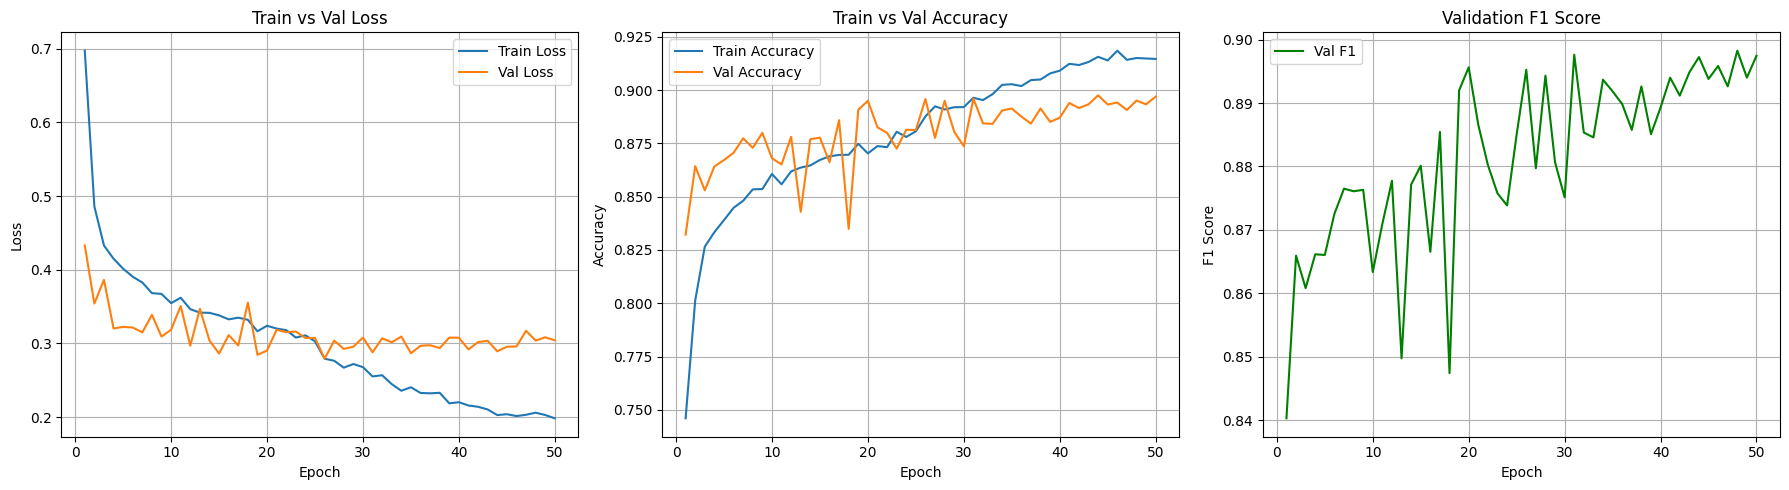


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:39<00:00, 39.77it/s]



====== Test Results ======
Overall Loss: 0.3076
Overall Accuracy: 0.8971
Cohen's Kappa: 0.8312
Per Class F1: [0.89641088 0.90146591 0.89645706]
Macro (Avg) F1: 0.8981


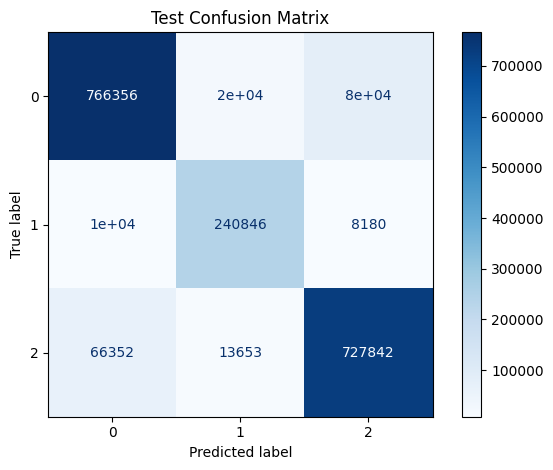

History Dumped in file /kaggle/working/deterministic_CNN_data_diversity_history.json_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_entropy.npz ======
Train Data:  (14000, 28, 6) (14000,)


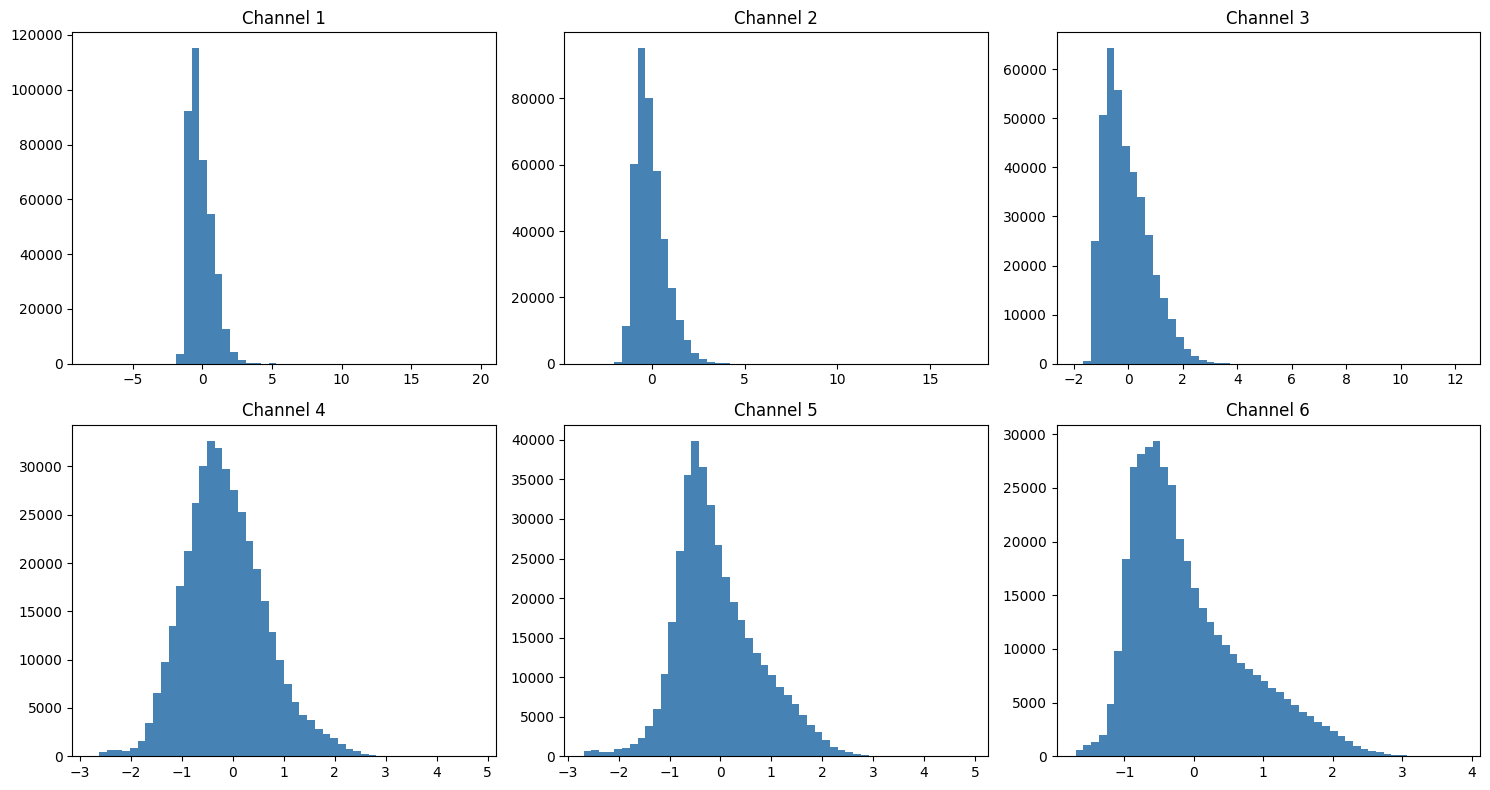

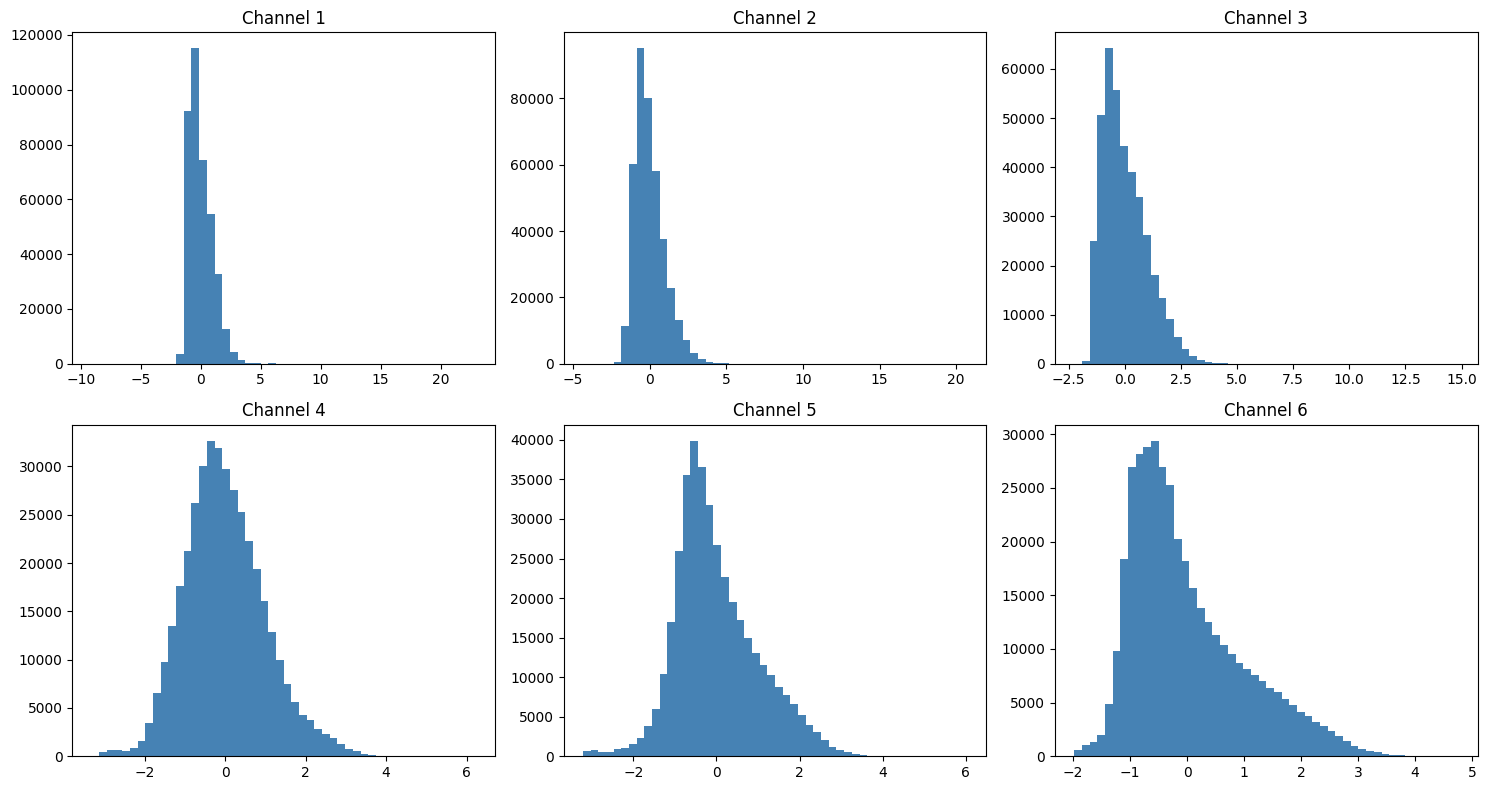



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         4432      31.66%
1         3632      25.94%
2         5936      42.40%

Total samples: 14000


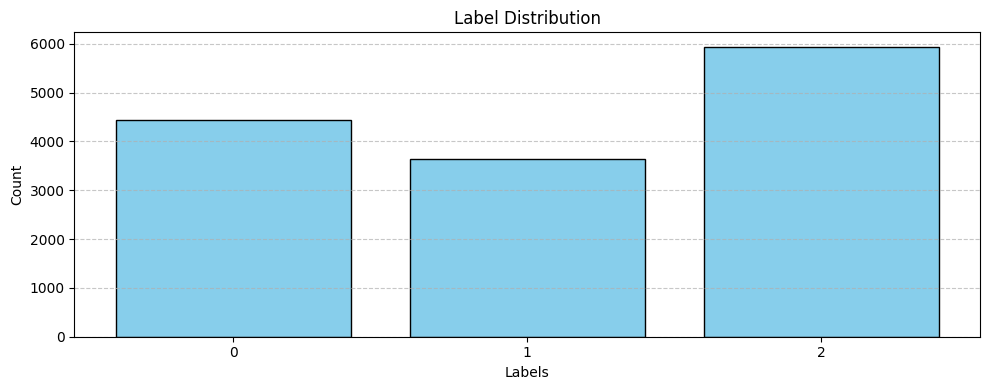


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


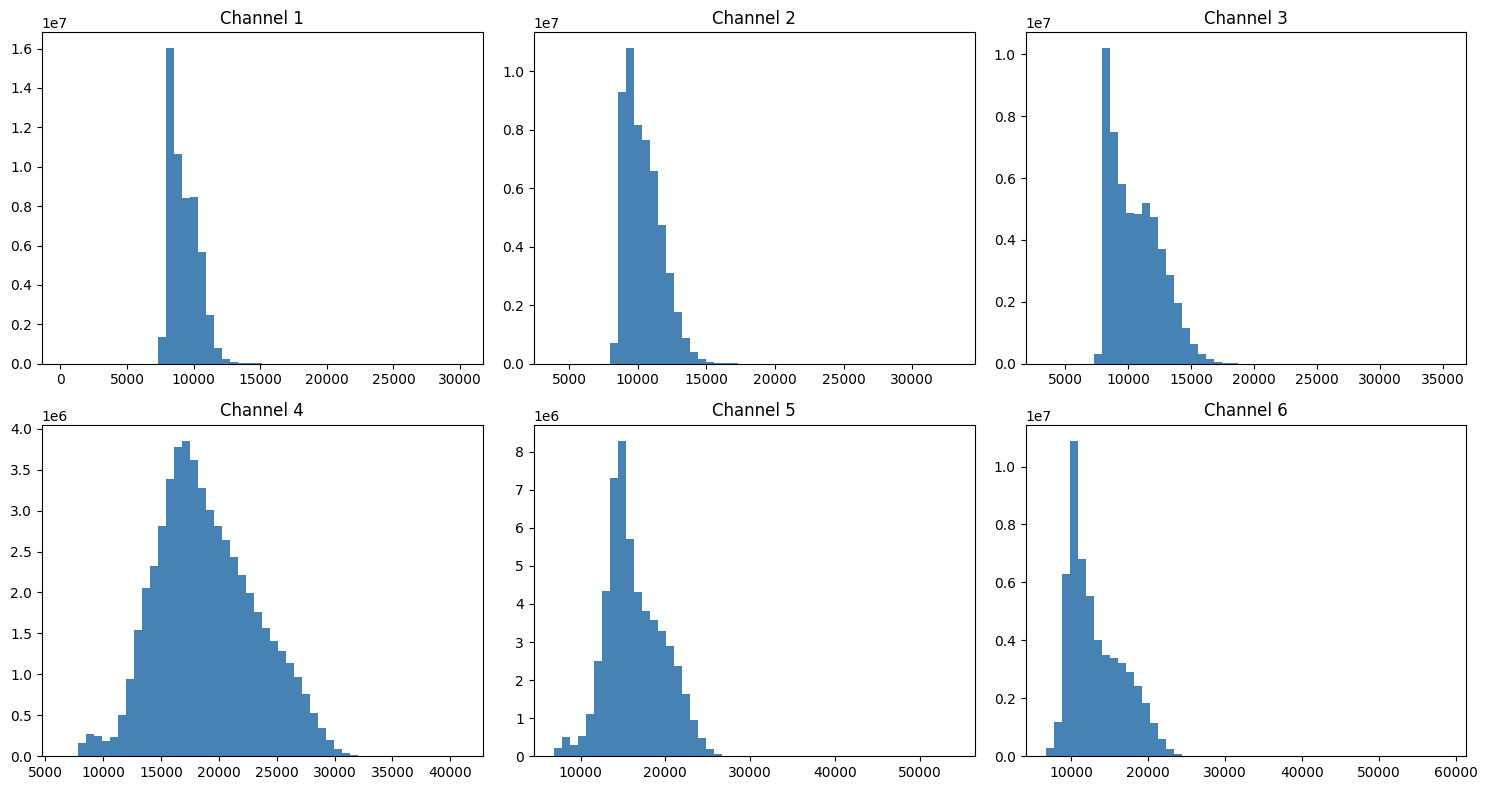

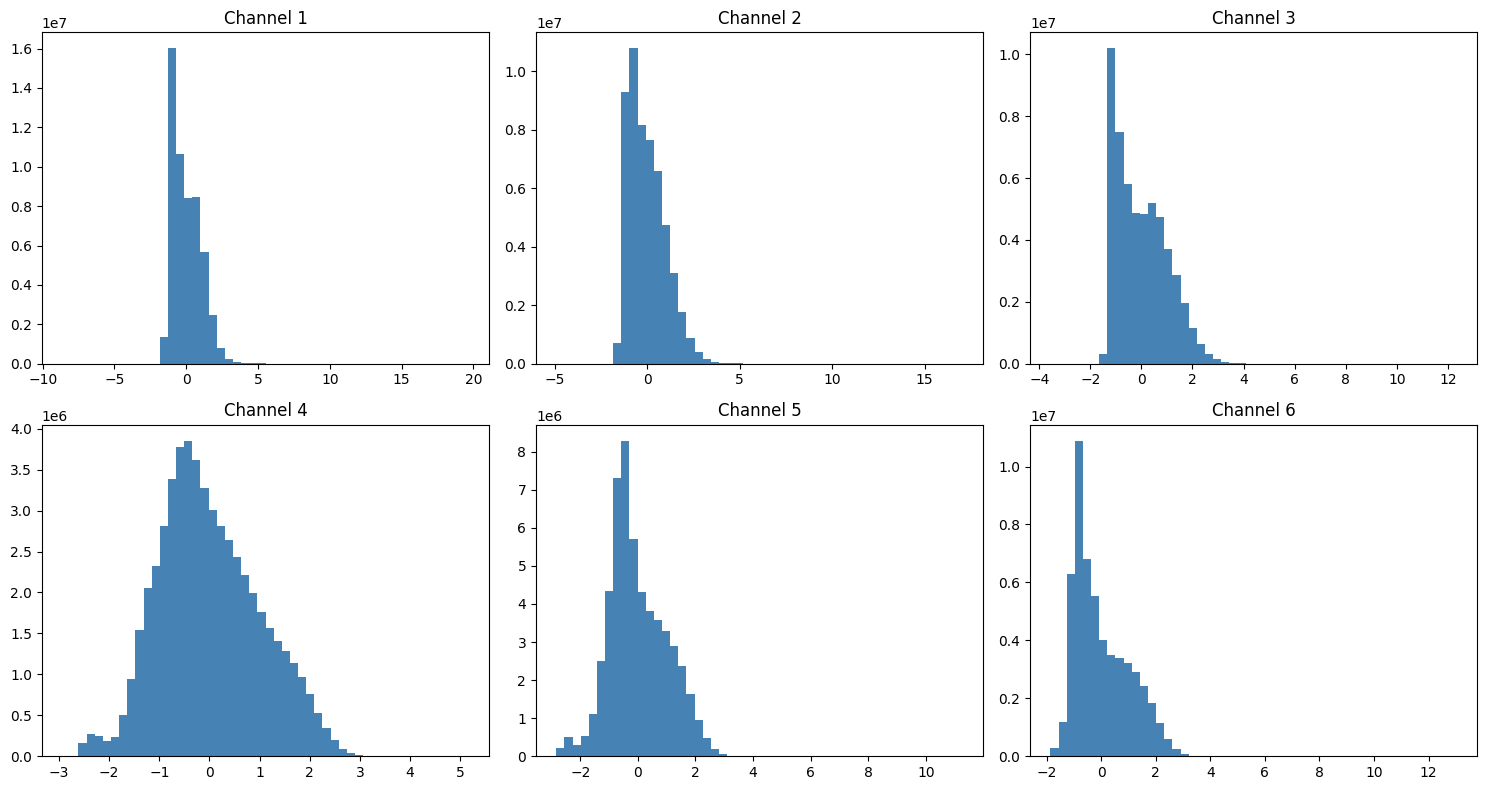



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


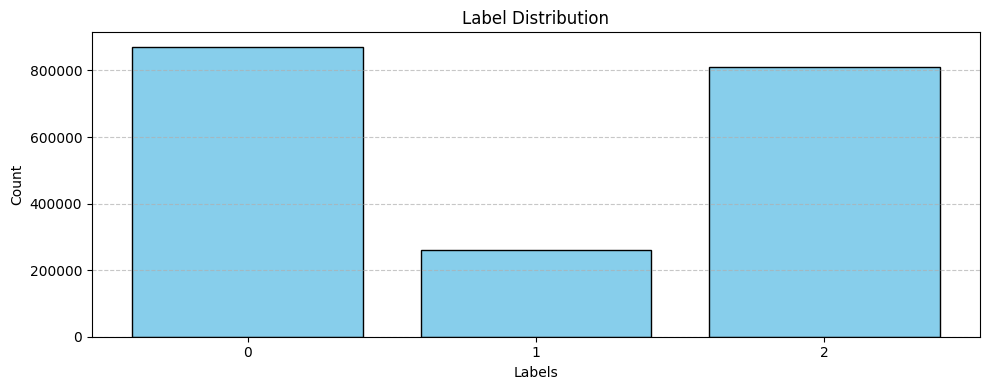

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.7193, 0.8263, 0.5801], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [1/50] Train Loss: 1.1009, Train Acc: 0.5412 | Val Loss: 0.5624, Val Acc: 0.8087, F1: 0.8186, Kappa: 0.6892


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [2/50] Train Loss: 0.8632, Train Acc: 0.5962 | Val Loss: 0.5233, Val Acc: 0.7725, F1: 0.7860, Kappa: 0.6249


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [3/50] Train Loss: 0.8146, Train Acc: 0.6206 | Val Loss: 0.4842, Val Acc: 0.8164, F1: 0.8244, Kappa: 0.7026


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [4/50] Train Loss: 0.7908, Train Acc: 0.6317 | Val Loss: 0.4234, Val Acc: 0.8454, F1: 0.8540, Kappa: 0.7466


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [5/50] Train Loss: 0.7743, Train Acc: 0.6389 | Val Loss: 0.4128, Val Acc: 0.8634, F1: 0.8707, Kappa: 0.7747


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [6/50] Train Loss: 0.7603, Train Acc: 0.6479 | Val Loss: 0.4422, Val Acc: 0.8397, F1: 0.8493, Kappa: 0.7380


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [7/50] Train Loss: 0.7486, Train Acc: 0.6486 | Val Loss: 0.3952, Val Acc: 0.8663, F1: 0.8724, Kappa: 0.7799


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [8/50] Train Loss: 0.7428, Train Acc: 0.6599 | Val Loss: 0.4224, Val Acc: 0.8597, F1: 0.8589, Kappa: 0.7717


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [9/50] Train Loss: 0.7379, Train Acc: 0.6561 | Val Loss: 0.4156, Val Acc: 0.8548, F1: 0.8592, Kappa: 0.7632


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [10/50] Train Loss: 0.7258, Train Acc: 0.6663 | Val Loss: 0.3815, Val Acc: 0.8769, F1: 0.8829, Kappa: 0.7969


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [11/50] Train Loss: 0.7207, Train Acc: 0.6681 | Val Loss: 0.3796, Val Acc: 0.8578, F1: 0.8605, Kappa: 0.7688


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [12/50] Train Loss: 0.7156, Train Acc: 0.6738 | Val Loss: 0.3957, Val Acc: 0.8548, F1: 0.8598, Kappa: 0.7632


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [13/50] Train Loss: 0.7063, Train Acc: 0.6749 | Val Loss: 0.3820, Val Acc: 0.8620, F1: 0.8688, Kappa: 0.7731


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [14/50] Train Loss: 0.7015, Train Acc: 0.6781 | Val Loss: 0.3383, Val Acc: 0.8792, F1: 0.8851, Kappa: 0.8012


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [15/50] Train Loss: 0.6985, Train Acc: 0.6831 | Val Loss: 0.3571, Val Acc: 0.8716, F1: 0.8791, Kappa: 0.7884


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [16/50] Train Loss: 0.6894, Train Acc: 0.6862 | Val Loss: 0.3610, Val Acc: 0.8760, F1: 0.8821, Kappa: 0.7961


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [17/50] Train Loss: 0.6835, Train Acc: 0.6852 | Val Loss: 0.3433, Val Acc: 0.8806, F1: 0.8871, Kappa: 0.8031


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [18/50] Train Loss: 0.6855, Train Acc: 0.6896 | Val Loss: 0.3237, Val Acc: 0.8837, F1: 0.8885, Kappa: 0.8091


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [19/50] Train Loss: 0.6765, Train Acc: 0.6957 | Val Loss: 0.3507, Val Acc: 0.8739, F1: 0.8759, Kappa: 0.7941


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [20/50] Train Loss: 0.6711, Train Acc: 0.6946 | Val Loss: 0.3402, Val Acc: 0.8735, F1: 0.8784, Kappa: 0.7922


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [21/50] Train Loss: 0.6680, Train Acc: 0.6980 | Val Loss: 0.3350, Val Acc: 0.8836, F1: 0.8886, Kappa: 0.8090


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [22/50] Train Loss: 0.6570, Train Acc: 0.7056 | Val Loss: 0.3429, Val Acc: 0.8827, F1: 0.8894, Kappa: 0.8066


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [23/50] Train Loss: 0.6582, Train Acc: 0.7044 | Val Loss: 0.3310, Val Acc: 0.8824, F1: 0.8853, Kappa: 0.8067


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [24/50] Train Loss: 0.6557, Train Acc: 0.7006 | Val Loss: 0.3445, Val Acc: 0.8799, F1: 0.8810, Kappa: 0.8039


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [25/50] Train Loss: 0.6230, Train Acc: 0.7170 | Val Loss: 0.3079, Val Acc: 0.8921, F1: 0.8968, Kappa: 0.8223


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [26/50] Train Loss: 0.6188, Train Acc: 0.7238 | Val Loss: 0.3111, Val Acc: 0.8898, F1: 0.8931, Kappa: 0.8188


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.96it/s]


Epoch [27/50] Train Loss: 0.6099, Train Acc: 0.7265 | Val Loss: 0.2981, Val Acc: 0.8951, F1: 0.9001, Kappa: 0.8264


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [28/50] Train Loss: 0.6099, Train Acc: 0.7268 | Val Loss: 0.3076, Val Acc: 0.8945, F1: 0.8987, Kappa: 0.8263


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [29/50] Train Loss: 0.6050, Train Acc: 0.7308 | Val Loss: 0.3104, Val Acc: 0.8945, F1: 0.8974, Kappa: 0.8262


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [30/50] Train Loss: 0.6037, Train Acc: 0.7302 | Val Loss: 0.3323, Val Acc: 0.8853, F1: 0.8880, Kappa: 0.8111


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [31/50] Train Loss: 0.5990, Train Acc: 0.7309 | Val Loss: 0.3155, Val Acc: 0.8894, F1: 0.8929, Kappa: 0.8181


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [32/50] Train Loss: 0.5948, Train Acc: 0.7321 | Val Loss: 0.3692, Val Acc: 0.8651, F1: 0.8720, Kappa: 0.7769


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [33/50] Train Loss: 0.5959, Train Acc: 0.7356 | Val Loss: 0.3368, Val Acc: 0.8756, F1: 0.8826, Kappa: 0.7954


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.99it/s]


Epoch [34/50] Train Loss: 0.5641, Train Acc: 0.7539 | Val Loss: 0.3163, Val Acc: 0.8897, F1: 0.8933, Kappa: 0.8182


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [35/50] Train Loss: 0.5680, Train Acc: 0.7507 | Val Loss: 0.3090, Val Acc: 0.8935, F1: 0.8970, Kappa: 0.8250


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [36/50] Train Loss: 0.5585, Train Acc: 0.7538 | Val Loss: 0.3257, Val Acc: 0.8840, F1: 0.8909, Kappa: 0.8088


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [37/50] Train Loss: 0.5562, Train Acc: 0.7531 | Val Loss: 0.3060, Val Acc: 0.8964, F1: 0.9008, Kappa: 0.8293


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [38/50] Train Loss: 0.5528, Train Acc: 0.7573 | Val Loss: 0.3264, Val Acc: 0.8882, F1: 0.8887, Kappa: 0.8148


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [39/50] Train Loss: 0.5530, Train Acc: 0.7572 | Val Loss: 0.3223, Val Acc: 0.8906, F1: 0.8955, Kappa: 0.8199


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [40/50] Train Loss: 0.5359, Train Acc: 0.7664 | Val Loss: 0.3128, Val Acc: 0.8917, F1: 0.8960, Kappa: 0.8214


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [41/50] Train Loss: 0.5325, Train Acc: 0.7663 | Val Loss: 0.3020, Val Acc: 0.8947, F1: 0.8989, Kappa: 0.8268


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [42/50] Train Loss: 0.5309, Train Acc: 0.7671 | Val Loss: 0.2998, Val Acc: 0.8965, F1: 0.9012, Kappa: 0.8295


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [43/50] Train Loss: 0.5275, Train Acc: 0.7680 | Val Loss: 0.3062, Val Acc: 0.8957, F1: 0.8997, Kappa: 0.8283


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [44/50] Train Loss: 0.5253, Train Acc: 0.7699 | Val Loss: 0.3064, Val Acc: 0.8928, F1: 0.8974, Kappa: 0.8238


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [45/50] Train Loss: 0.5215, Train Acc: 0.7727 | Val Loss: 0.3033, Val Acc: 0.8955, F1: 0.8986, Kappa: 0.8281


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [46/50] Train Loss: 0.5116, Train Acc: 0.7749 | Val Loss: 0.3122, Val Acc: 0.8949, F1: 0.8989, Kappa: 0.8269


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [47/50] Train Loss: 0.5072, Train Acc: 0.7794 | Val Loss: 0.3094, Val Acc: 0.8957, F1: 0.8990, Kappa: 0.8283


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [48/50] Train Loss: 0.5113, Train Acc: 0.7781 | Val Loss: 0.3049, Val Acc: 0.8948, F1: 0.8987, Kappa: 0.8267


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [49/50] Train Loss: 0.5140, Train Acc: 0.7734 | Val Loss: 0.3057, Val Acc: 0.8984, F1: 0.9017, Kappa: 0.8325


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [50/50] Train Loss: 0.5051, Train Acc: 0.7786 | Val Loss: 0.3091, Val Acc: 0.8948, F1: 0.8992, Kappa: 0.8267


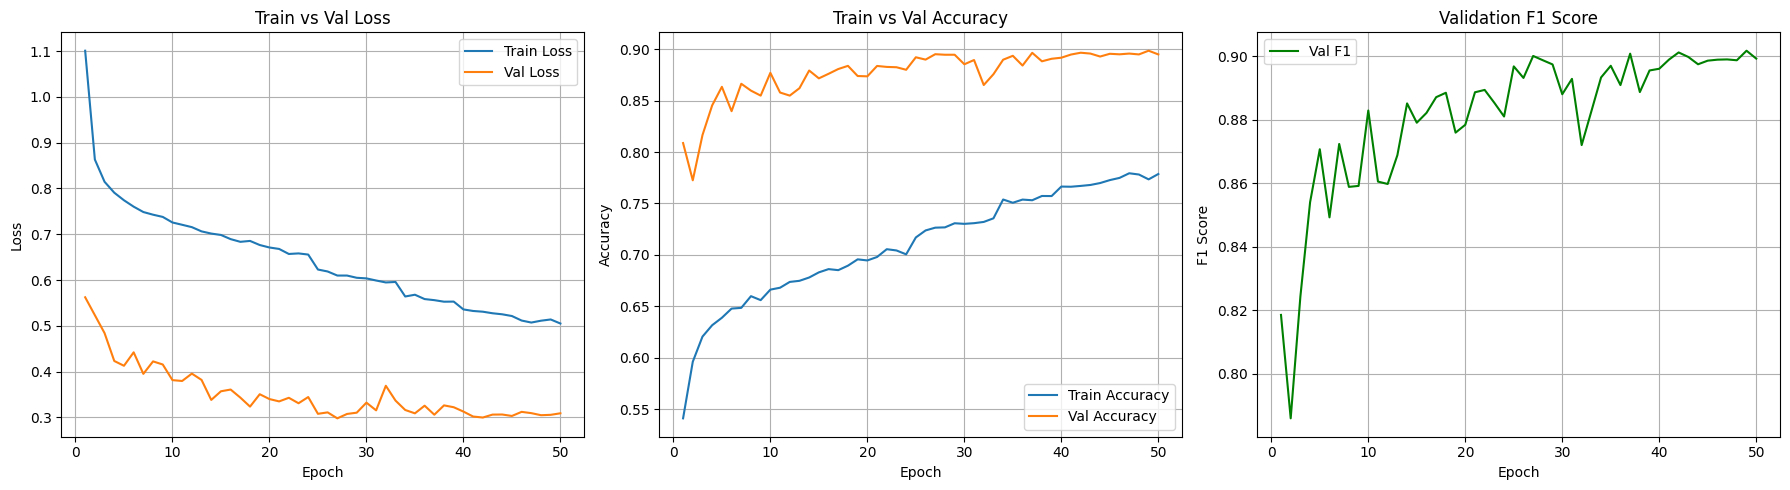


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:40<00:00, 39.71it/s]



====== Test Results ======
Overall Loss: 0.3131
Overall Accuracy: 0.8955
Cohen's Kappa: 0.8274
Per Class F1: [0.89408002 0.91502639 0.8907367 ]
Macro (Avg) F1: 0.8999


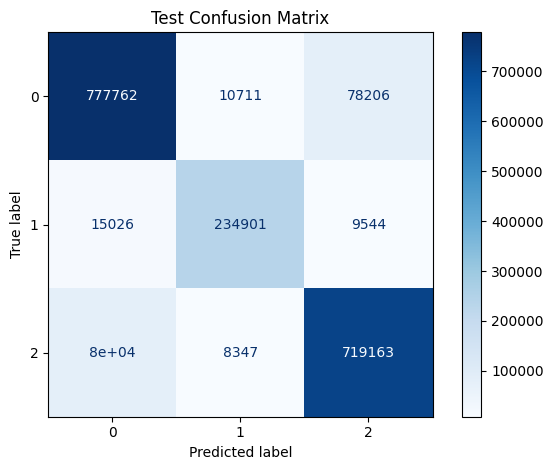

History Dumped in file /kaggle/working/deterministic_CNN_data_entropy_history.json_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_entropy_diversity.npz ======
Train Data:  (14000, 28, 6) (14000,)


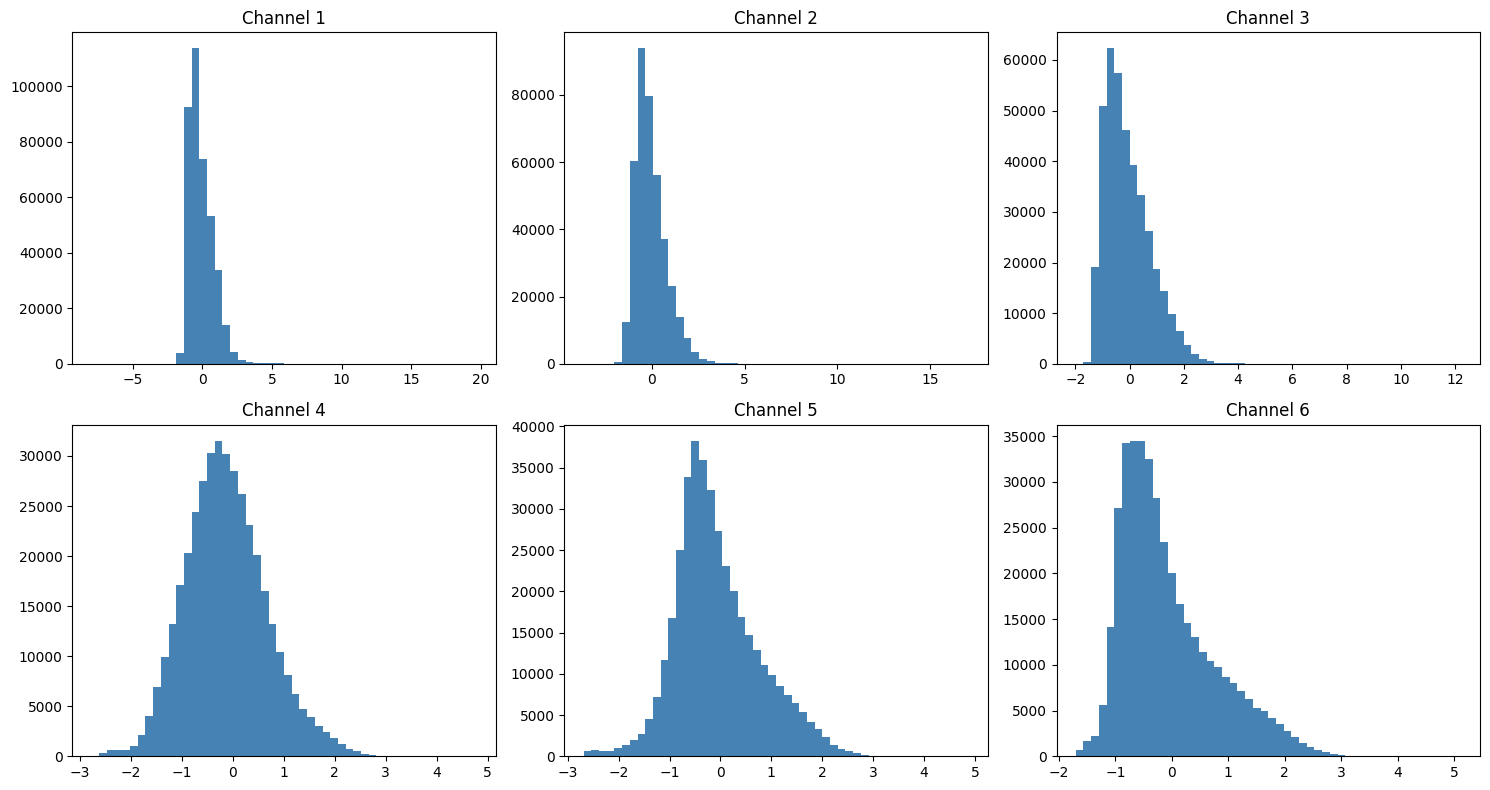

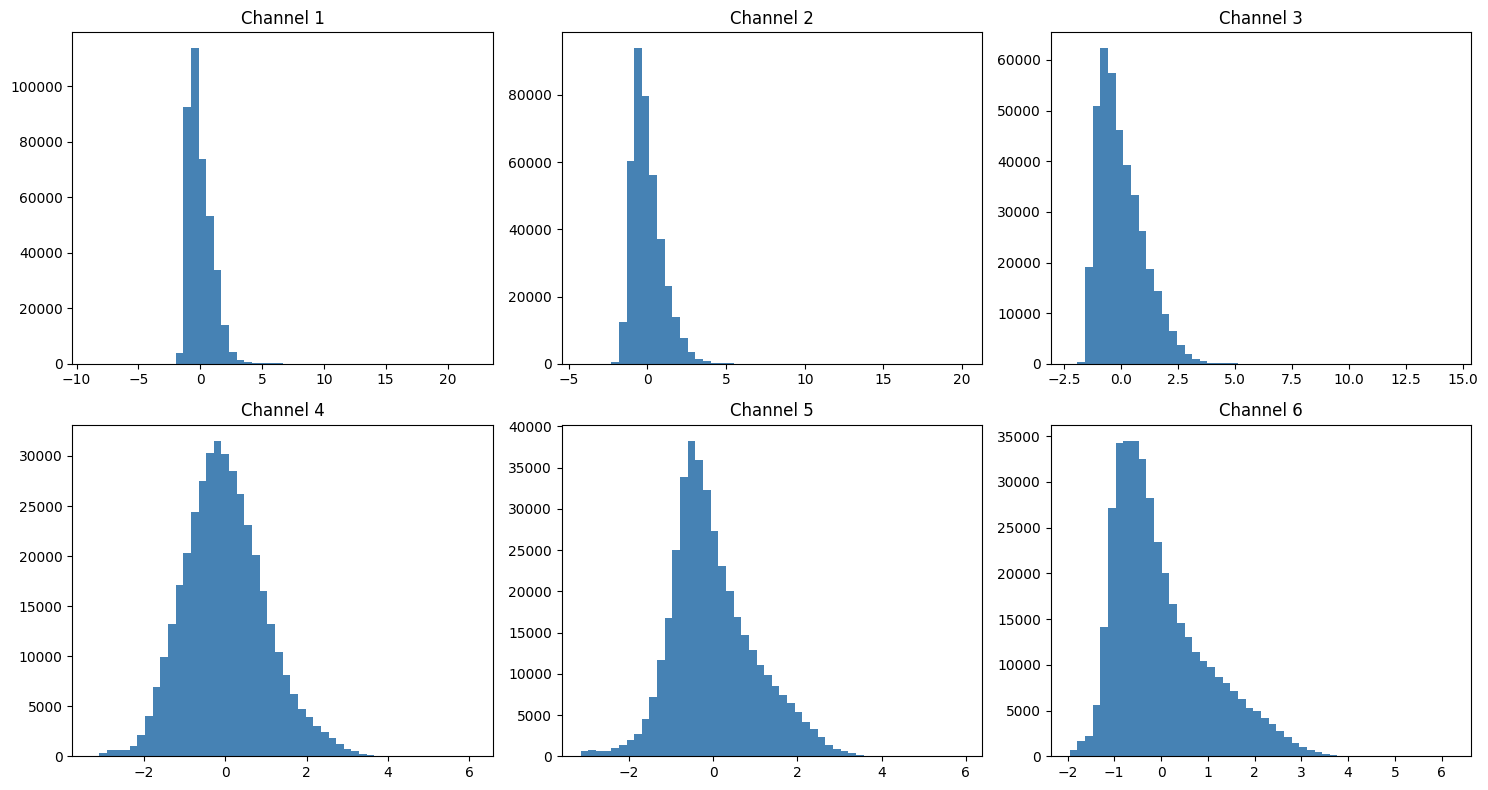



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         5459      38.99%
1         1899      13.56%
2         6642      47.44%

Total samples: 14000


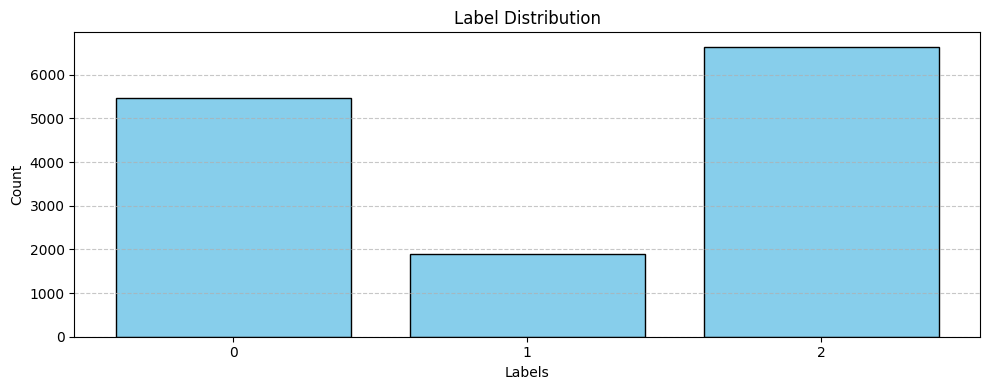


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


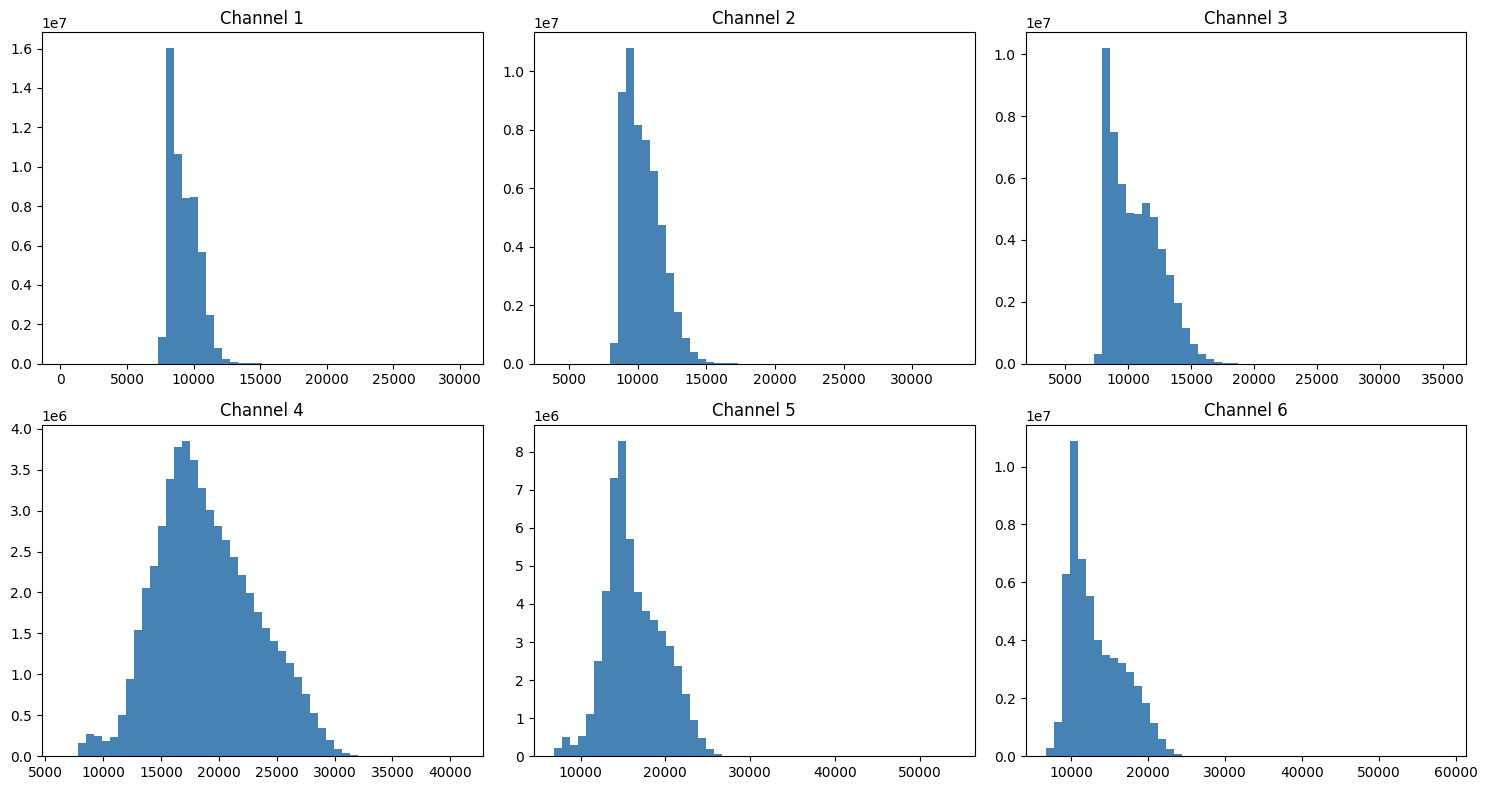

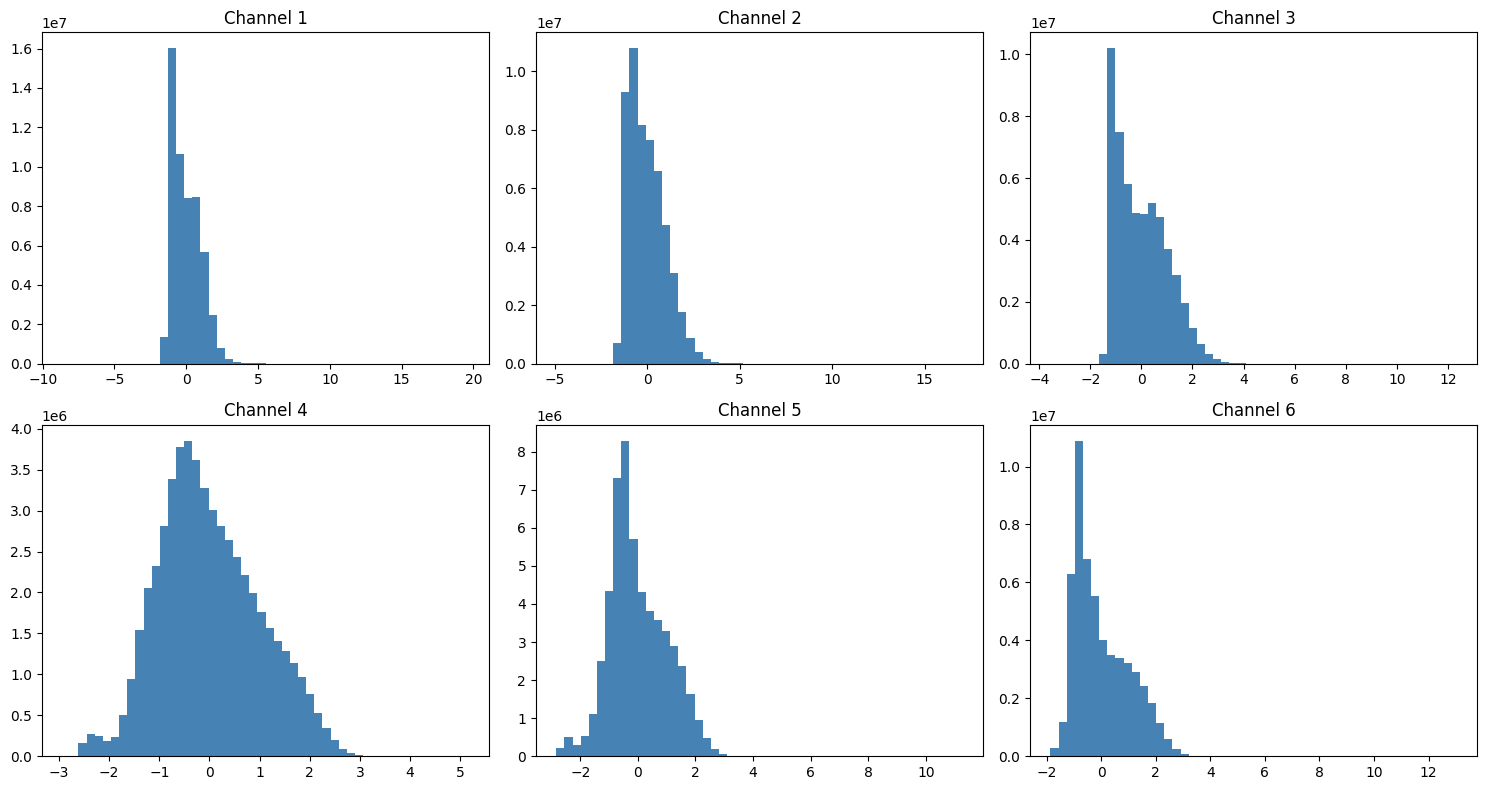



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


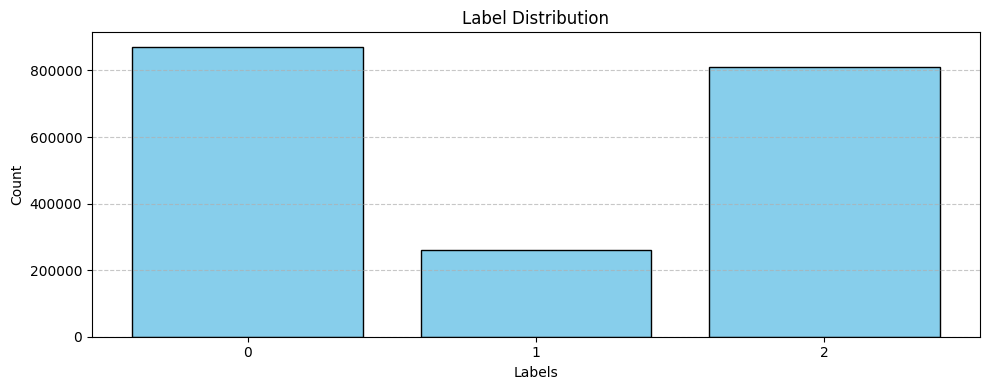

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.6178, 1.2405, 0.5322], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [1/50] Train Loss: 1.1487, Train Acc: 0.5179 | Val Loss: 0.6287, Val Acc: 0.7474, F1: 0.7432, Kappa: 0.6002


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [2/50] Train Loss: 0.9182, Train Acc: 0.5617 | Val Loss: 0.5538, Val Acc: 0.8152, F1: 0.8193, Kappa: 0.7014


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.71it/s]


Epoch [3/50] Train Loss: 0.8844, Train Acc: 0.5793 | Val Loss: 0.4612, Val Acc: 0.8532, F1: 0.8589, Kappa: 0.7588


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [4/50] Train Loss: 0.8518, Train Acc: 0.6015 | Val Loss: 0.4603, Val Acc: 0.8189, F1: 0.8305, Kappa: 0.7054


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [5/50] Train Loss: 0.8372, Train Acc: 0.5959 | Val Loss: 0.4578, Val Acc: 0.8230, F1: 0.8328, Kappa: 0.7123


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [6/50] Train Loss: 0.8202, Train Acc: 0.6104 | Val Loss: 0.4562, Val Acc: 0.8125, F1: 0.8273, Kappa: 0.6939


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [7/50] Train Loss: 0.8081, Train Acc: 0.6222 | Val Loss: 0.4077, Val Acc: 0.8566, F1: 0.8569, Kappa: 0.7665


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [8/50] Train Loss: 0.8041, Train Acc: 0.6241 | Val Loss: 0.4265, Val Acc: 0.8495, F1: 0.8568, Kappa: 0.7535


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [9/50] Train Loss: 0.7866, Train Acc: 0.6295 | Val Loss: 0.4038, Val Acc: 0.8587, F1: 0.8596, Kappa: 0.7700


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [10/50] Train Loss: 0.7865, Train Acc: 0.6319 | Val Loss: 0.4083, Val Acc: 0.8495, F1: 0.8517, Kappa: 0.7540


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [11/50] Train Loss: 0.7706, Train Acc: 0.6367 | Val Loss: 0.3796, Val Acc: 0.8688, F1: 0.8682, Kappa: 0.7859


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [12/50] Train Loss: 0.7630, Train Acc: 0.6414 | Val Loss: 0.3531, Val Acc: 0.8758, F1: 0.8755, Kappa: 0.7977


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [13/50] Train Loss: 0.7634, Train Acc: 0.6449 | Val Loss: 0.4123, Val Acc: 0.8584, F1: 0.8570, Kappa: 0.7704


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [14/50] Train Loss: 0.7522, Train Acc: 0.6452 | Val Loss: 0.3936, Val Acc: 0.8341, F1: 0.8425, Kappa: 0.7305


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [15/50] Train Loss: 0.7471, Train Acc: 0.6528 | Val Loss: 0.3755, Val Acc: 0.8610, F1: 0.8640, Kappa: 0.7730


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [16/50] Train Loss: 0.7443, Train Acc: 0.6524 | Val Loss: 0.3464, Val Acc: 0.8806, F1: 0.8808, Kappa: 0.8051


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [17/50] Train Loss: 0.7372, Train Acc: 0.6601 | Val Loss: 0.3595, Val Acc: 0.8695, F1: 0.8644, Kappa: 0.7891


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.00it/s]


Epoch [18/50] Train Loss: 0.7305, Train Acc: 0.6588 | Val Loss: 0.3674, Val Acc: 0.8493, F1: 0.8524, Kappa: 0.7554


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [19/50] Train Loss: 0.7273, Train Acc: 0.6661 | Val Loss: 0.3254, Val Acc: 0.8736, F1: 0.8725, Kappa: 0.7947


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [20/50] Train Loss: 0.7200, Train Acc: 0.6648 | Val Loss: 0.3116, Val Acc: 0.8818, F1: 0.8826, Kappa: 0.8071


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [21/50] Train Loss: 0.7188, Train Acc: 0.6699 | Val Loss: 0.3363, Val Acc: 0.8827, F1: 0.8836, Kappa: 0.8081


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [22/50] Train Loss: 0.7135, Train Acc: 0.6676 | Val Loss: 0.3327, Val Acc: 0.8795, F1: 0.8775, Kappa: 0.8038


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [23/50] Train Loss: 0.7068, Train Acc: 0.6777 | Val Loss: 0.3527, Val Acc: 0.8754, F1: 0.8792, Kappa: 0.7948


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [24/50] Train Loss: 0.7055, Train Acc: 0.6719 | Val Loss: 0.3062, Val Acc: 0.8870, F1: 0.8853, Kappa: 0.8159


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [25/50] Train Loss: 0.6989, Train Acc: 0.6771 | Val Loss: 0.3046, Val Acc: 0.8885, F1: 0.8888, Kappa: 0.8175


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [26/50] Train Loss: 0.6929, Train Acc: 0.6846 | Val Loss: 0.3159, Val Acc: 0.8896, F1: 0.8902, Kappa: 0.8195


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [27/50] Train Loss: 0.6855, Train Acc: 0.6899 | Val Loss: 0.3283, Val Acc: 0.8882, F1: 0.8909, Kappa: 0.8163


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [28/50] Train Loss: 0.6850, Train Acc: 0.6856 | Val Loss: 0.3299, Val Acc: 0.8848, F1: 0.8871, Kappa: 0.8113


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.87it/s]


Epoch [29/50] Train Loss: 0.6800, Train Acc: 0.6892 | Val Loss: 0.3181, Val Acc: 0.8850, F1: 0.8836, Kappa: 0.8124


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [30/50] Train Loss: 0.6757, Train Acc: 0.6901 | Val Loss: 0.3160, Val Acc: 0.8894, F1: 0.8926, Kappa: 0.8187


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.90it/s]


Epoch [31/50] Train Loss: 0.6687, Train Acc: 0.6998 | Val Loss: 0.2905, Val Acc: 0.8935, F1: 0.8910, Kappa: 0.8265


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.97it/s]


Epoch [32/50] Train Loss: 0.6649, Train Acc: 0.6986 | Val Loss: 0.3014, Val Acc: 0.8955, F1: 0.8982, Kappa: 0.8281


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [33/50] Train Loss: 0.6659, Train Acc: 0.6956 | Val Loss: 0.3229, Val Acc: 0.8841, F1: 0.8854, Kappa: 0.8105


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [34/50] Train Loss: 0.6529, Train Acc: 0.7029 | Val Loss: 0.3036, Val Acc: 0.8861, F1: 0.8852, Kappa: 0.8139


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [35/50] Train Loss: 0.6570, Train Acc: 0.6992 | Val Loss: 0.3031, Val Acc: 0.8956, F1: 0.8979, Kappa: 0.8287


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [36/50] Train Loss: 0.6514, Train Acc: 0.7041 | Val Loss: 0.3035, Val Acc: 0.8908, F1: 0.8910, Kappa: 0.8216


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [37/50] Train Loss: 0.6370, Train Acc: 0.7149 | Val Loss: 0.3076, Val Acc: 0.8894, F1: 0.8905, Kappa: 0.8192


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.69it/s]


Epoch [38/50] Train Loss: 0.6102, Train Acc: 0.7251 | Val Loss: 0.2995, Val Acc: 0.8948, F1: 0.8951, Kappa: 0.8273


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [39/50] Train Loss: 0.5955, Train Acc: 0.7344 | Val Loss: 0.3006, Val Acc: 0.8948, F1: 0.8982, Kappa: 0.8272


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [40/50] Train Loss: 0.5954, Train Acc: 0.7324 | Val Loss: 0.2897, Val Acc: 0.8970, F1: 0.8986, Kappa: 0.8313


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [41/50] Train Loss: 0.5851, Train Acc: 0.7373 | Val Loss: 0.3014, Val Acc: 0.8942, F1: 0.8983, Kappa: 0.8262


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.73it/s]


Epoch [42/50] Train Loss: 0.5800, Train Acc: 0.7416 | Val Loss: 0.2937, Val Acc: 0.8987, F1: 0.9012, Kappa: 0.8332


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [43/50] Train Loss: 0.5767, Train Acc: 0.7404 | Val Loss: 0.2993, Val Acc: 0.8978, F1: 0.9005, Kappa: 0.8322


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [44/50] Train Loss: 0.5684, Train Acc: 0.7439 | Val Loss: 0.2913, Val Acc: 0.8968, F1: 0.9005, Kappa: 0.8305


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [45/50] Train Loss: 0.5682, Train Acc: 0.7465 | Val Loss: 0.3041, Val Acc: 0.8921, F1: 0.8935, Kappa: 0.8235


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [46/50] Train Loss: 0.5590, Train Acc: 0.7495 | Val Loss: 0.2960, Val Acc: 0.8930, F1: 0.8954, Kappa: 0.8251


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [47/50] Train Loss: 0.5420, Train Acc: 0.7544 | Val Loss: 0.2817, Val Acc: 0.9028, F1: 0.9037, Kappa: 0.8406


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [48/50] Train Loss: 0.5363, Train Acc: 0.7606 | Val Loss: 0.2923, Val Acc: 0.9014, F1: 0.9043, Kappa: 0.8379


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [49/50] Train Loss: 0.5264, Train Acc: 0.7671 | Val Loss: 0.2976, Val Acc: 0.8974, F1: 0.8987, Kappa: 0.8317


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [50/50] Train Loss: 0.5318, Train Acc: 0.7591 | Val Loss: 0.3017, Val Acc: 0.8968, F1: 0.8958, Kappa: 0.8310


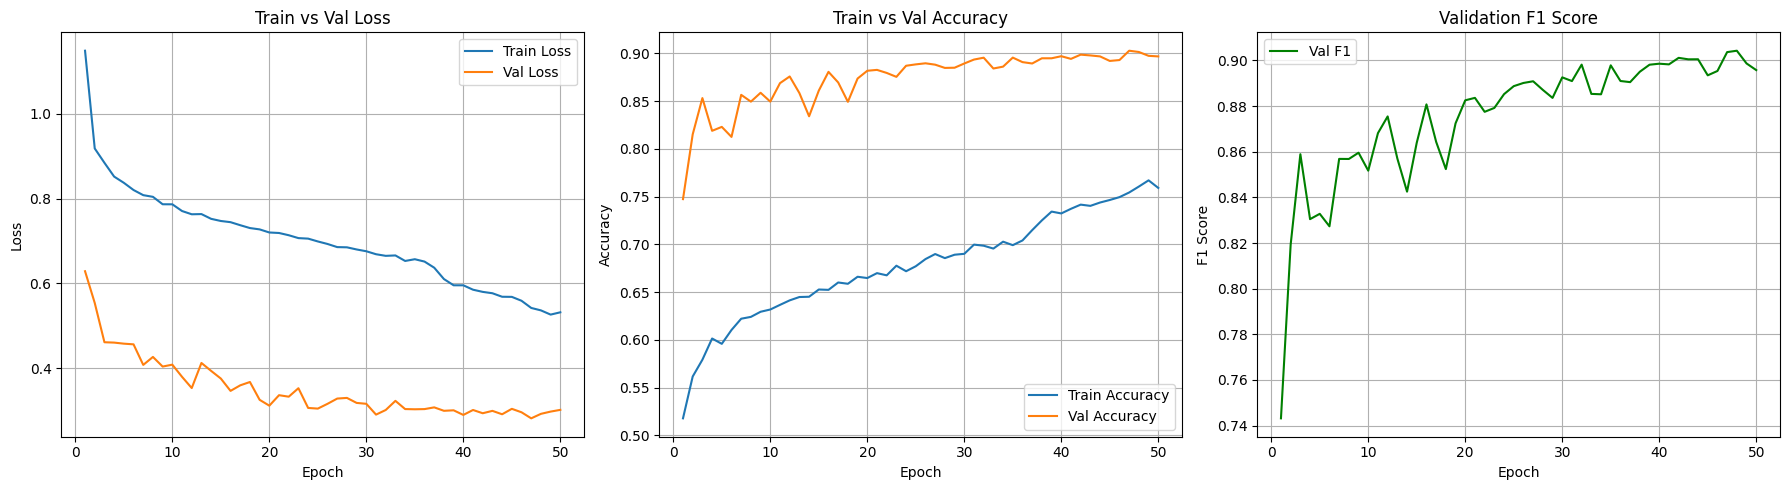


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:41<00:00, 39.69it/s]



====== Test Results ======
Overall Loss: 0.3038
Overall Accuracy: 0.8955
Cohen's Kappa: 0.8285
Per Class F1: [0.89848989 0.89506794 0.89238744]
Macro (Avg) F1: 0.8953


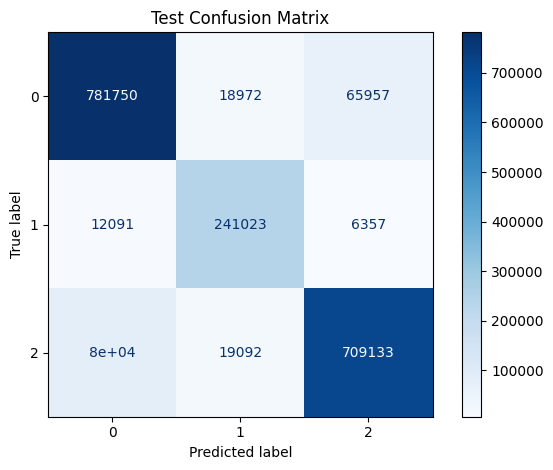

History Dumped in file /kaggle/working/deterministic_CNN_data_entropy_diversity_history.json_history.json


====== Loading Data /kaggle/input/data-al/deterministic_CNN_data_margin.npz ======
Train Data:  (14000, 28, 6) (14000,)


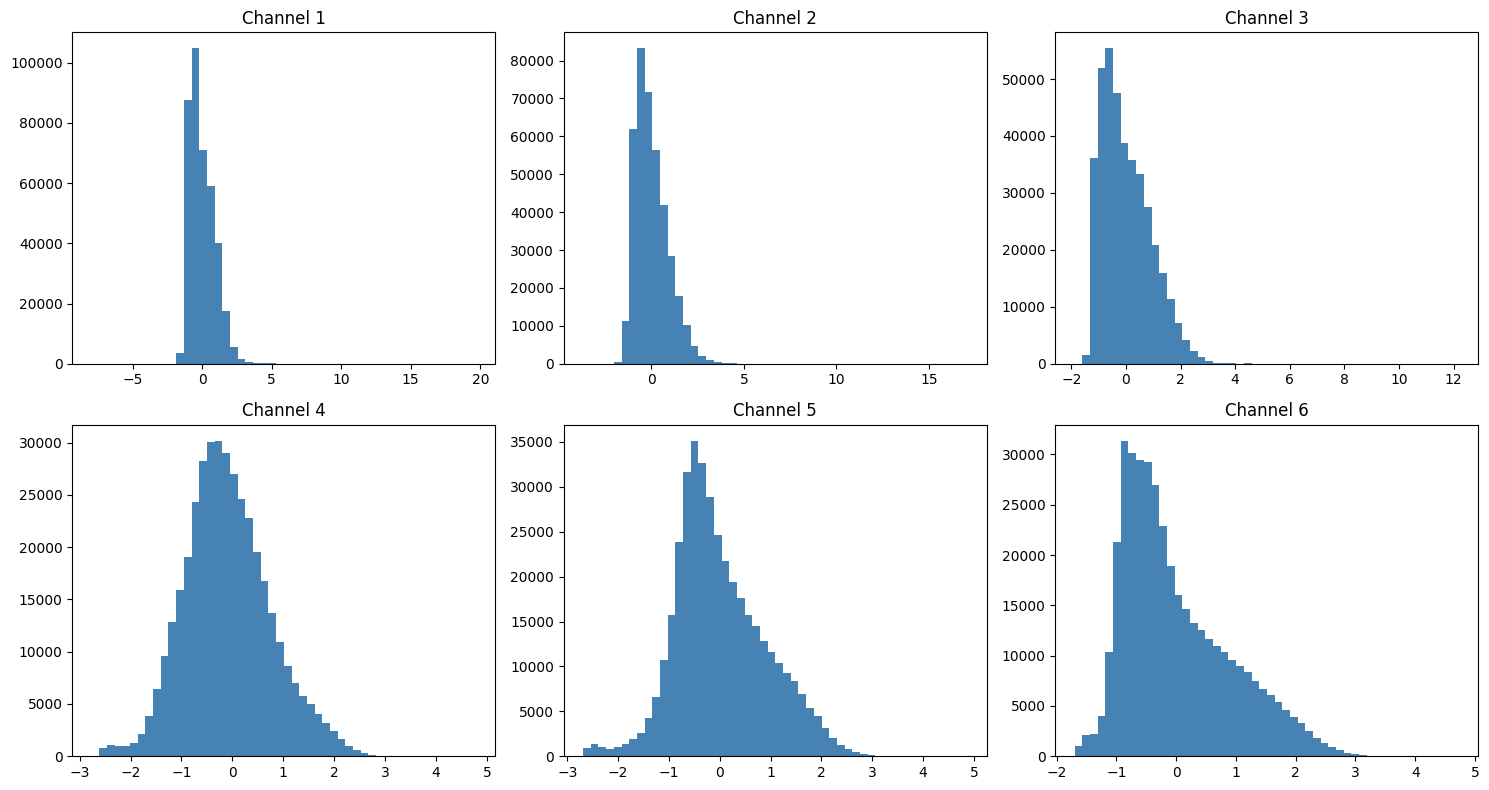

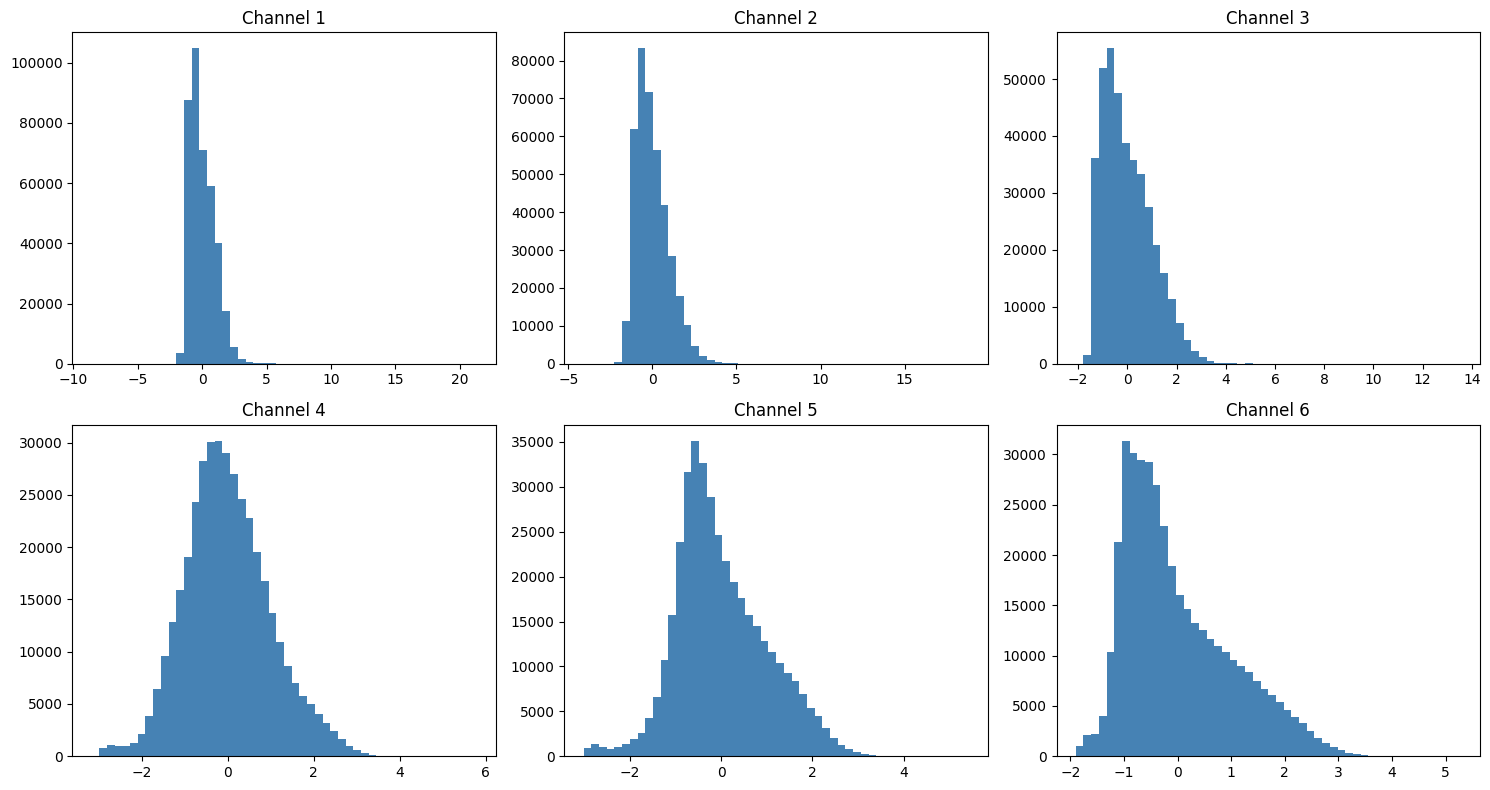



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         6375      45.54%
1         1412      10.09%
2         6213      44.38%

Total samples: 14000


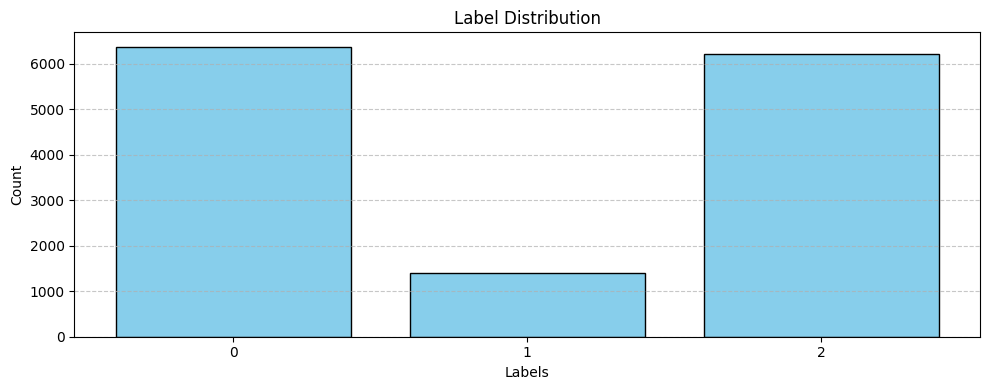


====== Loading Data Site B - 2020 ======
Site B - 2020 Data: (1943716, 28, 6), (1943716,)


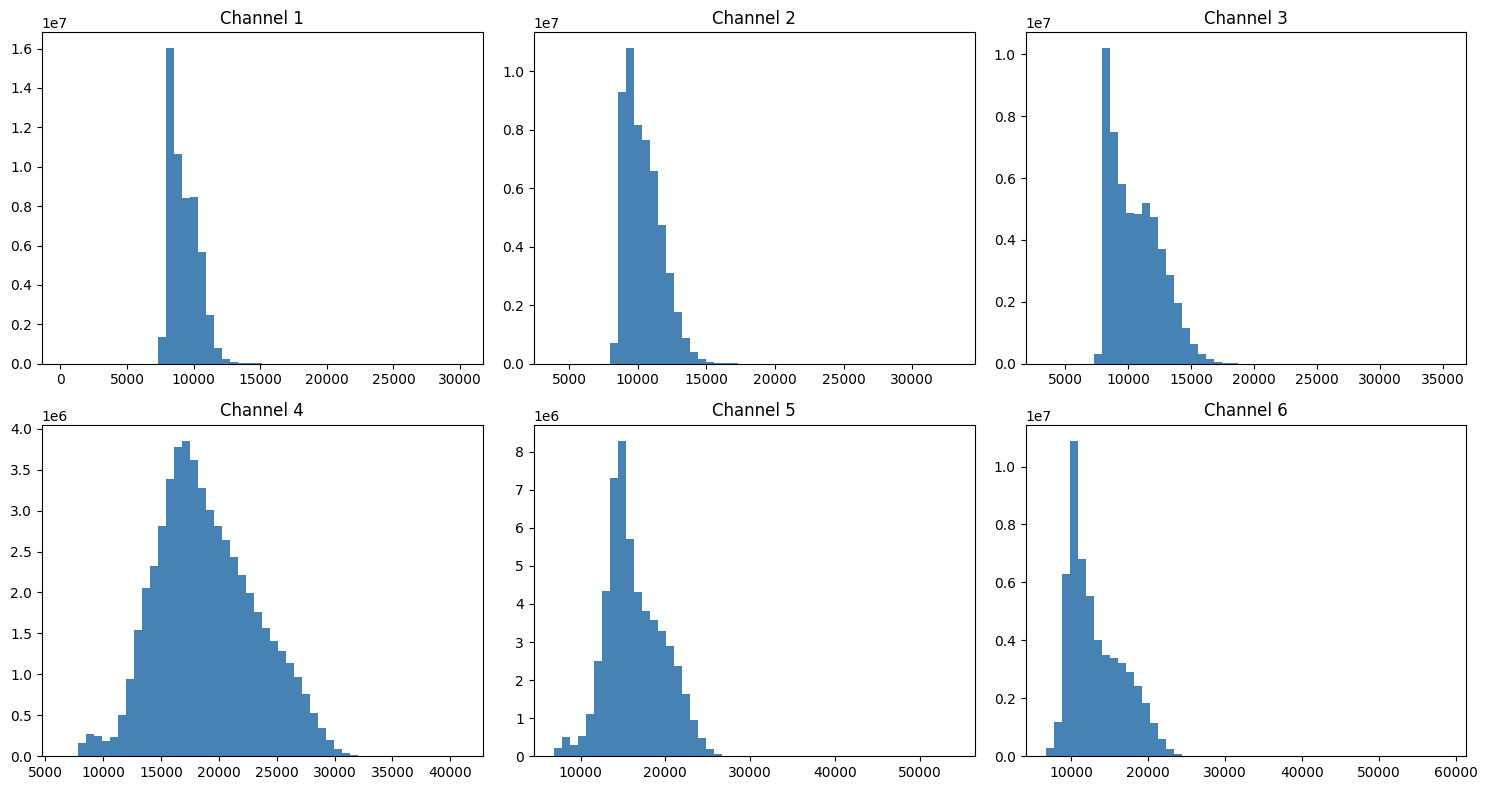

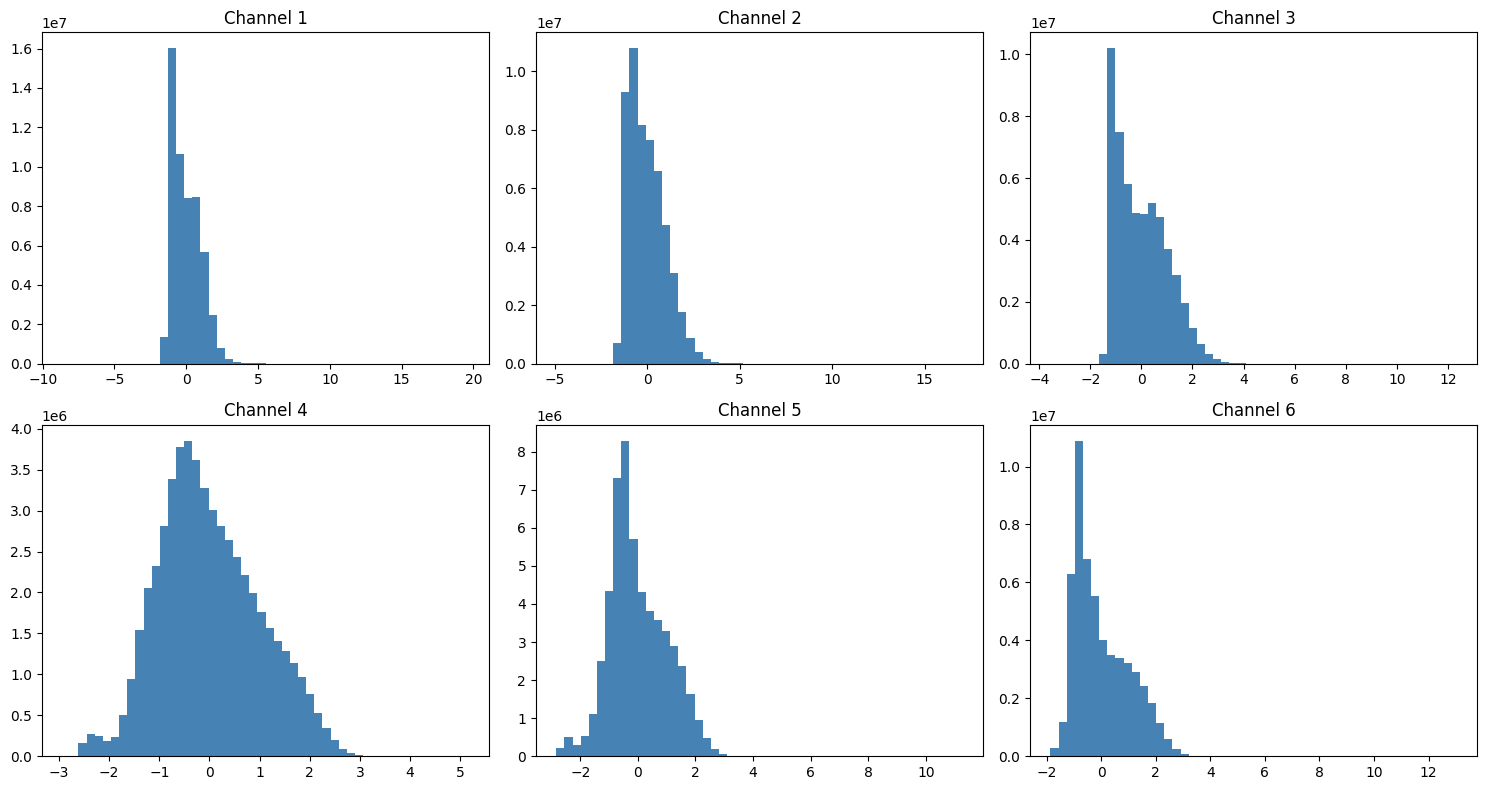



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


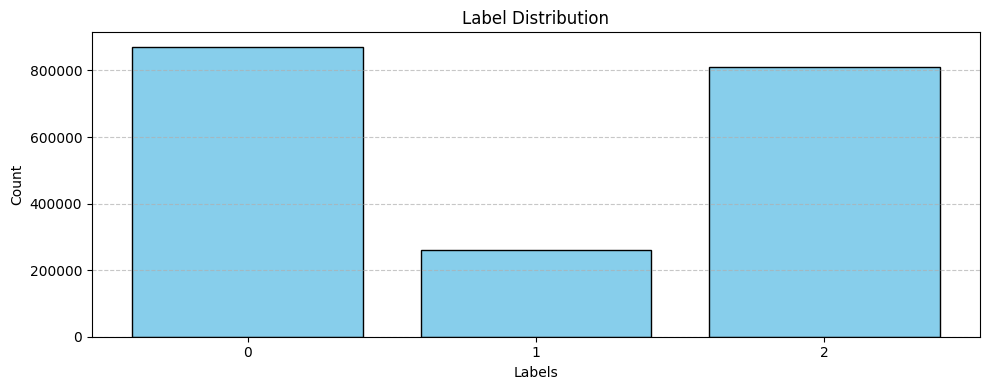

Val Data:  (9719, 28, 6) (9719,)
Test Data:  (1933997, 28, 6) (1933997,)
tensor([0.5493, 1.4598, 0.5603], device='cuda:0')

====== Training the Model ======


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.82it/s]


Epoch [1/50] Train Loss: 1.1049, Train Acc: 0.5232 | Val Loss: 0.5415, Val Acc: 0.8359, F1: 0.8415, Kappa: 0.7311


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [2/50] Train Loss: 0.8404, Train Acc: 0.5730 | Val Loss: 0.5256, Val Acc: 0.8328, F1: 0.8412, Kappa: 0.7247


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [3/50] Train Loss: 0.7980, Train Acc: 0.5866 | Val Loss: 0.5029, Val Acc: 0.7503, F1: 0.7721, Kappa: 0.5941


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.86it/s]


Epoch [4/50] Train Loss: 0.7847, Train Acc: 0.5945 | Val Loss: 0.4610, Val Acc: 0.8239, F1: 0.8383, Kappa: 0.7120


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [5/50] Train Loss: 0.7582, Train Acc: 0.6123 | Val Loss: 0.4670, Val Acc: 0.8598, F1: 0.8627, Kappa: 0.7697


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.75it/s]


Epoch [6/50] Train Loss: 0.7463, Train Acc: 0.6220 | Val Loss: 0.3899, Val Acc: 0.8586, F1: 0.8645, Kappa: 0.7693


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [7/50] Train Loss: 0.7351, Train Acc: 0.6252 | Val Loss: 0.4374, Val Acc: 0.8556, F1: 0.8561, Kappa: 0.7652


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [8/50] Train Loss: 0.7220, Train Acc: 0.6304 | Val Loss: 0.3748, Val Acc: 0.8461, F1: 0.8534, Kappa: 0.7494


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [9/50] Train Loss: 0.7168, Train Acc: 0.6378 | Val Loss: 0.3711, Val Acc: 0.8765, F1: 0.8791, Kappa: 0.7981


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [10/50] Train Loss: 0.7096, Train Acc: 0.6386 | Val Loss: 0.3791, Val Acc: 0.8627, F1: 0.8613, Kappa: 0.7777


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [11/50] Train Loss: 0.7001, Train Acc: 0.6470 | Val Loss: 0.4281, Val Acc: 0.8534, F1: 0.8534, Kappa: 0.7608


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [12/50] Train Loss: 0.6974, Train Acc: 0.6468 | Val Loss: 0.3816, Val Acc: 0.8798, F1: 0.8860, Kappa: 0.8024


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [13/50] Train Loss: 0.6868, Train Acc: 0.6566 | Val Loss: 0.3469, Val Acc: 0.8852, F1: 0.8918, Kappa: 0.8109


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [14/50] Train Loss: 0.6755, Train Acc: 0.6659 | Val Loss: 0.3418, Val Acc: 0.8891, F1: 0.8925, Kappa: 0.8173


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [15/50] Train Loss: 0.6703, Train Acc: 0.6706 | Val Loss: 0.3497, Val Acc: 0.8920, F1: 0.8926, Kappa: 0.8221


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [16/50] Train Loss: 0.6721, Train Acc: 0.6649 | Val Loss: 0.3549, Val Acc: 0.8918, F1: 0.8942, Kappa: 0.8218


Validation: 100%|██████████| 152/152 [00:03<00:00, 40.00it/s]


Epoch [17/50] Train Loss: 0.6599, Train Acc: 0.6780 | Val Loss: 0.3835, Val Acc: 0.8710, F1: 0.8747, Kappa: 0.7874


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [18/50] Train Loss: 0.6656, Train Acc: 0.6755 | Val Loss: 0.3309, Val Acc: 0.8856, F1: 0.8859, Kappa: 0.8130


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.93it/s]


Epoch [19/50] Train Loss: 0.6565, Train Acc: 0.6814 | Val Loss: 0.3853, Val Acc: 0.8930, F1: 0.8922, Kappa: 0.8228


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [20/50] Train Loss: 0.6478, Train Acc: 0.6846 | Val Loss: 0.3228, Val Acc: 0.8781, F1: 0.8801, Kappa: 0.8014


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [21/50] Train Loss: 0.6388, Train Acc: 0.6877 | Val Loss: 0.3127, Val Acc: 0.8926, F1: 0.8961, Kappa: 0.8237


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.91it/s]


Epoch [22/50] Train Loss: 0.6333, Train Acc: 0.6860 | Val Loss: 0.3036, Val Acc: 0.9017, F1: 0.9026, Kappa: 0.8384


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.92it/s]


Epoch [23/50] Train Loss: 0.6298, Train Acc: 0.6927 | Val Loss: 0.3066, Val Acc: 0.8962, F1: 0.8998, Kappa: 0.8296


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [24/50] Train Loss: 0.6310, Train Acc: 0.6966 | Val Loss: 0.3439, Val Acc: 0.8795, F1: 0.8782, Kappa: 0.8037


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.94it/s]


Epoch [25/50] Train Loss: 0.6210, Train Acc: 0.6985 | Val Loss: 0.4005, Val Acc: 0.8740, F1: 0.8589, Kappa: 0.7912


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.97it/s]


Epoch [26/50] Train Loss: 0.6190, Train Acc: 0.7002 | Val Loss: 0.3060, Val Acc: 0.8946, F1: 0.8950, Kappa: 0.8279


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [27/50] Train Loss: 0.6096, Train Acc: 0.7071 | Val Loss: 0.3000, Val Acc: 0.9001, F1: 0.9009, Kappa: 0.8362


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.95it/s]


Epoch [28/50] Train Loss: 0.6060, Train Acc: 0.7026 | Val Loss: 0.3265, Val Acc: 0.9005, F1: 0.9035, Kappa: 0.8362


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.98it/s]


Epoch [29/50] Train Loss: 0.6125, Train Acc: 0.7080 | Val Loss: 0.3100, Val Acc: 0.8836, F1: 0.8858, Kappa: 0.8102


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.76it/s]


Epoch [30/50] Train Loss: 0.6009, Train Acc: 0.7119 | Val Loss: 0.3228, Val Acc: 0.8869, F1: 0.8922, Kappa: 0.8141


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [31/50] Train Loss: 0.5951, Train Acc: 0.7094 | Val Loss: 0.3358, Val Acc: 0.8840, F1: 0.8899, Kappa: 0.8087


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.83it/s]


Epoch [32/50] Train Loss: 0.5877, Train Acc: 0.7153 | Val Loss: 0.2964, Val Acc: 0.9013, F1: 0.9006, Kappa: 0.8378


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.85it/s]


Epoch [33/50] Train Loss: 0.5857, Train Acc: 0.7231 | Val Loss: 0.2871, Val Acc: 0.8988, F1: 0.8980, Kappa: 0.8343


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [34/50] Train Loss: 0.5766, Train Acc: 0.7221 | Val Loss: 0.2964, Val Acc: 0.9022, F1: 0.9008, Kappa: 0.8400


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.89it/s]


Epoch [35/50] Train Loss: 0.5752, Train Acc: 0.7241 | Val Loss: 0.3011, Val Acc: 0.9016, F1: 0.9017, Kappa: 0.8386


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.88it/s]


Epoch [36/50] Train Loss: 0.5733, Train Acc: 0.7272 | Val Loss: 0.2875, Val Acc: 0.9048, F1: 0.9075, Kappa: 0.8436


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.84it/s]


Epoch [37/50] Train Loss: 0.5649, Train Acc: 0.7307 | Val Loss: 0.2896, Val Acc: 0.8994, F1: 0.8997, Kappa: 0.8352


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [38/50] Train Loss: 0.5641, Train Acc: 0.7289 | Val Loss: 0.3089, Val Acc: 0.8980, F1: 0.8977, Kappa: 0.8329


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [39/50] Train Loss: 0.5626, Train Acc: 0.7308 | Val Loss: 0.3447, Val Acc: 0.8949, F1: 0.8906, Kappa: 0.8259


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [40/50] Train Loss: 0.5224, Train Acc: 0.7538 | Val Loss: 0.3095, Val Acc: 0.8979, F1: 0.8976, Kappa: 0.8325


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.72it/s]


Epoch [41/50] Train Loss: 0.5123, Train Acc: 0.7529 | Val Loss: 0.2840, Val Acc: 0.9076, F1: 0.9094, Kappa: 0.8480


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [42/50] Train Loss: 0.5048, Train Acc: 0.7594 | Val Loss: 0.2829, Val Acc: 0.9052, F1: 0.9045, Kappa: 0.8446


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [43/50] Train Loss: 0.5089, Train Acc: 0.7534 | Val Loss: 0.3046, Val Acc: 0.9044, F1: 0.9054, Kappa: 0.8425


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.79it/s]


Epoch [44/50] Train Loss: 0.4965, Train Acc: 0.7614 | Val Loss: 0.2822, Val Acc: 0.9086, F1: 0.9096, Kappa: 0.8499


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.81it/s]


Epoch [45/50] Train Loss: 0.4964, Train Acc: 0.7672 | Val Loss: 0.2938, Val Acc: 0.9061, F1: 0.9055, Kappa: 0.8460


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.77it/s]


Epoch [46/50] Train Loss: 0.4873, Train Acc: 0.7698 | Val Loss: 0.2861, Val Acc: 0.9060, F1: 0.9056, Kappa: 0.8459


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.74it/s]


Epoch [47/50] Train Loss: 0.4883, Train Acc: 0.7716 | Val Loss: 0.2980, Val Acc: 0.9055, F1: 0.9044, Kappa: 0.8445


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.80it/s]


Epoch [48/50] Train Loss: 0.4727, Train Acc: 0.7761 | Val Loss: 0.2945, Val Acc: 0.9084, F1: 0.9091, Kappa: 0.8497


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [49/50] Train Loss: 0.4818, Train Acc: 0.7709 | Val Loss: 0.2962, Val Acc: 0.9063, F1: 0.9065, Kappa: 0.8460


Validation: 100%|██████████| 152/152 [00:03<00:00, 39.78it/s]


Epoch [50/50] Train Loss: 0.4704, Train Acc: 0.7793 | Val Loss: 0.2823, Val Acc: 0.9078, F1: 0.9092, Kappa: 0.8487


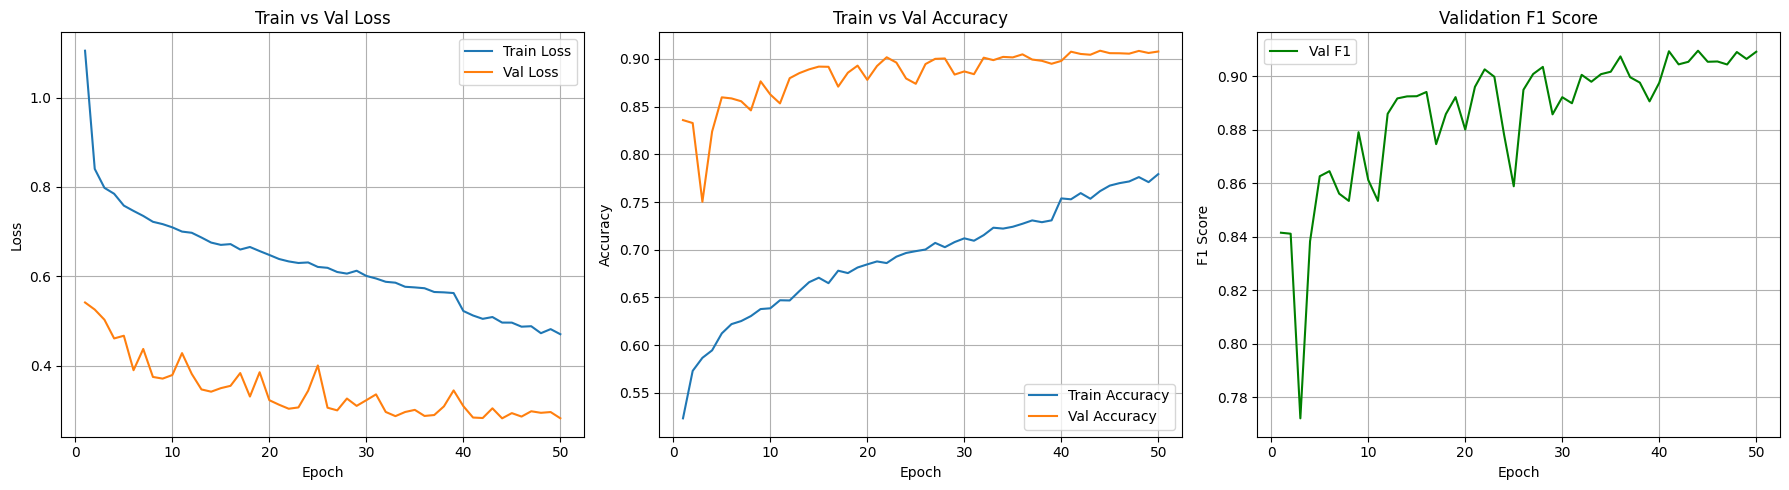


====== Testing the Model ======


Validation: 100%|██████████| 30219/30219 [12:41<00:00, 39.70it/s]



====== Test Results ======
Overall Loss: 0.2792
Overall Accuracy: 0.9055
Cohen's Kappa: 0.8447
Per Class F1: [0.90443448 0.91248622 0.90426832]
Macro (Avg) F1: 0.9071


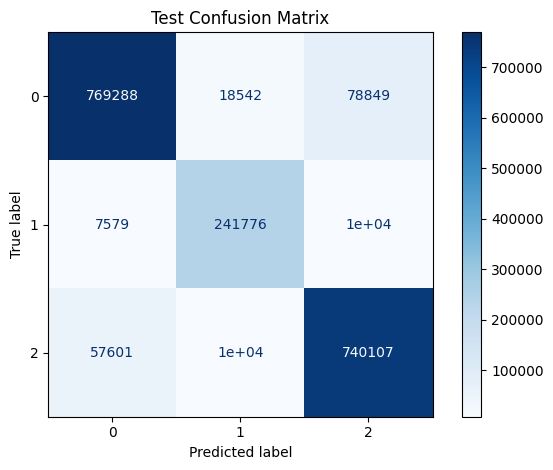

History Dumped in file /kaggle/working/deterministic_CNN_data_margin_history.json_history.json
Saved history of all files to approx_BCNN_training_evaluation.xlsx


In [18]:
for name in file_names:
    print(f'\n\n====== Loading Data {name} ======')
    X_train, y_train = load_data(name)
    
    if X_train.shape[1:] == (6,28):
        X_train = X_train.transpose(0,2,1)
    
    print('Train Data: ', X_train.shape, y_train.shape)
    plot_input_dist(X_train)
    X_train = normalize(X_train)
    plot_input_dist(X_train)
    plot_label_dist(y_train)

    print(f'\n====== Loading Data Site {SITE} - {YEAR} ======')
    X_B2020, y_B2020 = load_data(X_B2020_path, y_B2020_path)
    print(f'Site {SITE} - {YEAR} Data: {X_B2020.shape}, {y_B2020.shape}')
    plot_input_dist(X_B2020)
    X_B2020 = normalize(X_B2020)
    plot_input_dist(X_B2020)
    plot_label_dist(y_B2020)

    # Data Split
    X_test, X_val, y_test, y_val = train_test_split(X_B2020, y_B2020, test_size=0.005, stratify=y_B2020, random_state=42)
    print(f'Val Data: ', X_val.shape, y_val.shape)
    print(f'Test Data: ', X_test.shape, y_test.shape)

    # Creating datasets and dataloaders
    train_dataset = Conv1dDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    val_dataset = Conv1dDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = Conv1dDataset(X_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model Initialization
    backbone = cnn_dropout().to(DEVICE)
    fc = FC_dropout(1024).to(DEVICE)
    backbone.load_state_dict(backbone_state)
    fc.load_state_dict(fc_state)

    # ===== Class weights =====
    all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

    # Flatten labels and count occurrences
    flattened = all_labels.flatten()
    flattened = flattened[flattened >= 0]
    class_counts = np.bincount(flattened, minlength=NUM_CLASSES)
    total_pixels = class_counts.sum()
    
    # Inverse frequency (optionally normalize)
    class_weights = total_pixels / (NUM_CLASSES * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    class_weights = torch.log(1 + class_weights)
    print(class_weights)

    print(f'\n====== Training the Model ======')
    train_losses, val_losses, train_accs, val_accs, val_kappas, val_f1s, val_per_class_f1s = train(backbone, fc, train_dataloader, val_dataloader, DEVICE, class_weights=class_weights, epochs=EPOCHS, T=T)
    plot_loss_acc_f1s(train_losses, val_losses, train_accs, val_accs, val_f1s, EPOCHS=EPOCHS)

    print(f'\n====== Testing the Model ======')
    loss, acc, avg_f1, per_class_f1, kappa, cm = mc_dropout_eval(backbone, fc, test_dataloader, class_weights=class_weights, T=T)

    # Printing
    print(f'\n====== Test Results ======')
    print(f'Overall Loss: {loss:.4f}')
    print(f'Overall Accuracy: {acc:.4f}')
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f'Per Class F1: {per_class_f1}')
    print(f"Macro (Avg) F1: {avg_f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Test Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Logging History
    history[name]['train_loss'] = train_losses
    history[name]['train_acc'] = train_accs
    history[name]['val_loss'] = val_losses
    history[name]['val_acc'] = val_accs
    history[name]['val_f1s'] = val_f1s
    history[name]['val_kappas'] = val_kappas
    history[name]['val_per_class_f1s'] = val_per_class_f1s
    
    history[name]['overall_loss'] = float(loss)
    history[name]['overall_acc'] = float(acc)
    history[name]['kappa'] = float(kappa)
    history[name]['per_class_f1'] = per_class_f1.tolist() if isinstance(per_class_f1, (np.ndarray, list)) else per_class_f1
    history[name]['avg_f1'] = float(avg_f1)
    history[name]['cm'] = cm.tolist() if hasattr(cm, "tolist") else cm

    # Dumping History
    save_history(history[name], f"{name}_history.json")

    
# Saving the Results
save_results('approx_BCNN_training_evaluation', history)

<hr>